# CHAPTER 11. TRAINING DEEP NEURAL NETWORKS
In Chapter 10 you built, trained, and fine-tuned your first artificial neural networks. But they were shallow nets, with just a few hidden layers. What if you need to tackle a complex problem, such as detecting hundreds of types of objects in high-resolution images? You may need to train a much deeper ANN, perhaps with 10 layers or many more, each containing hundreds of neurons, linked by hundreds of thousands of connections. Training a deep neural network isn’t a walk in the park. Here are some of the problems you could run into:

- You may be faced with the problem of gradients growing ever smaller or larger, when flowing backward through the DNN during training. Both of these problems make lower layers very hard to train.

- You might not have enough training data for such a large network, or it might be too costly to label.

- Training may be extremely slow.

- A model with millions of parameters would severely risk overfitting the training set, especially if there are not enough training instances or if they are too noisy.

In this chapter we will go through each of these problems and present techniques to solve them. We will start by exploring the vanishing and exploding gradients problems and some of their most popular solutions. Next, we will look at transfer learning and unsupervised pretraining, which can help you tackle complex tasks even when you have little labeled data. Then we will discuss various optimizers that can speed up training large models tremendously. Finally, we will cover a few popular regularization techniques for large neural networks.

With these tools, you will be able to train very deep nets. Welcome to deep learning!

# THE VANISHING/EXPLODING GRADIENTS PROBLEMS
As discussed in Chapter 10, the backpropagation algorithm’s second phase works by going from the output layer to the input layer, propagating the error gradient along the way. Once the algorithm has computed the gradient of the cost function with regard to each parameter in the network, it uses these gradients to update each parameter with a gradient descent step.

Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the gradient descent update leaves the lower layers’ connection weights virtually unchanged, and training never converges to a good solution. This is called the vanishing gradients problem. In some cases, the opposite can happen: the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges. This is the exploding gradients problem, which surfaces most often in recurrent neural networks (see Chapter 15). More generally, deep neural networks suffer from unstable gradients; different layers may learn at widely different speeds.

This unfortunate behavior was empirically observed long ago, and it was one of the reasons deep neural networks were mostly abandoned in the early 2000s. It wasn’t clear what caused the gradients to be so unstable when training a DNN, but some light was shed in a 2010 paper by Xavier Glorot and Yoshua Bengio. The authors found a few suspects, including the combination of the popular sigmoid (logistic) activation function and the weight initialization technique that was most popular at the time (i.e., a normal distribution with a mean of 0 and a standard deviation of 1). In short, they showed that with this activation function and this initialization scheme, the variance of the outputs of each layer is much greater than the variance of its inputs. Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers. This saturation is actually made worse by the fact that the sigmoid function has a mean of 0.5, not 0 (the hyperbolic tangent function has a mean of 0 and behaves slightly better than the sigmoid function in deep networks).

Looking at the sigmoid activation function (see Figure 11-1), you can see that when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0 (i.e., the curve is flat at both extremes). Thus, when backpropagation kicks in it has virtually no gradient to propagate back through the network, and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

In [1]:
from packaging import version
import tensorflow as tf
import matplotlib.pyplot as plt
assert version.parse(tf.__version__) >= version.parse("2.8.0")

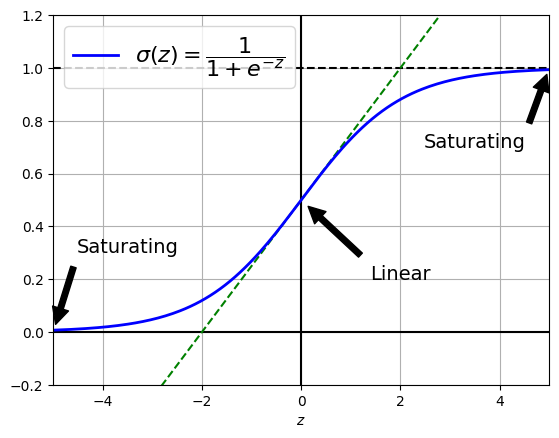

In [2]:
# extra code – this cell generates and saves Figure 11–1

import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

plt.show()

# Figure 11-1. Sigmoid activation function saturation

# GLOROT AND HE INITIALIZATION
In their paper, Glorot and Bengio propose a way to significantly alleviate the unstable gradients problem. They point out that we need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients. We don’t want the signal to die out, nor do we want it to explode and saturate. For the signal to flow properly, the authors argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we need the gradients to have equal variance before and after flowing through a layer in the reverse direction (please check out the paper if you are interested in the mathematical details). It is actually not possible to guarantee both unless the layer has an equal number of inputs and outputs (these numbers are called the fan-in and fan-out of the layer), but Glorot and Bengio proposed a good compromise that has proven to work very well in practice: the connection weights of each layer must be initialized randomly as described in Equation 11-1, where $fan_{avg} = (fan_{in} + fan_{out}) / 2$. This initialization strategy is called Xavier initialization or Glorot initialization, after the paper’s first author.

Equation 11-1. Glorot initialization (when using the sigmoid activation function)

Normal distribution with mean 0 and variance $\sigma^2 = \dfrac{1}{fan_{avg}}$\
Or uniform distribution betwenn $-r$ and $+r$, with $r = \sqrt{\dfrac{3}{fan_{avg}}}$


If you replace $fan_{avg}$ with $fan_{in}$ in Equation 11-1, you get an initialization strategy that Yann LeCun proposed in the 1990s. He called it LeCun initialization. Genevieve Orr and Klaus-Robert Müller even recommended it in their 1998 book Neural Networks: Tricks of the Trade (Springer). LeCun initialization is equivalent to Glorot initialization when $fan_{in}$ = $fan_{out}$. It took over a decade for researchers to realize how important this trick is. Using Glorot initialization can speed up training considerably, and it is one of the practices that led to the success of deep learning.

Some papers have provided similar strategies for different activation functions. These strategies differ only by the scale of the variance and whether they use $fan_{avg}$ or $fan_{in}$, as shown in Table 11-1 (for the uniform distribution, just use $r = \sqrt{3\sigma^2}$ ). The initialization strategy proposed for the ReLU activation function and its variants is called He initialization or Kaiming initialization, after the paper’s first author. For SELU, use Yann LeCun’s initialization method, preferably with a normal distribution. We will cover all these activation functions shortly.

Table 11-1. Initialization parameters for each type of activation function

| Initialization | Acitvation Functions                     | $\sigma^2$ (Normal) |
|----------------|------------------------------------------|---------------------|
| Glorot         | None, tanh, sigmoid, softmax             | $1/fan_{avg}$       |
| He             | ReLU, Leaky ReLU, ELU, GELU, Swish, Mish | $2/fan_{in}$        |
| LeCun          | SELU                                     | $1/fan_{in}$        |

By default, Keras uses Glorot initialization with a uniform distribution. When you create a layer, you can switch to He initialization by setting `kernel_initializer="he_uniform"` or `kernel_initializer="he_normal"` like this:

In [3]:
dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

Alternatively, you can obtain any of the initializations listed in Table 11-1 and more using the `VarianceScaling` initializer. For example, if you want He initialization with a uniform distribution and based on $fan_{avg}$ (rather than $fan_{in}$), you can use the following code:

In [4]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

# BETTER ACTIVATION FUNCTIONS
One of the insights in the 2010 paper by Glorot and Bengio was that the problems with unstable gradients were in part due to a poor choice of activation function. Until then most people had assumed that if Mother Nature had chosen to use roughly sigmoid activation functions in biological neurons, they must be an excellent choice. But it turns out that other activation functions behave much better in deep neural networks—in particular, the ReLU activation function, mostly because it does not saturate for positive values, and also because it is very fast to compute.

Unfortunately, the ReLU activation function is not perfect. It suffers from a problem known as the dying ReLUs: during training, some neurons effectively “die”, meaning they stop outputting anything other than 0. In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate. A neuron dies when its weights get tweaked in such a way that the input of the ReLU function (i.e., the weighted sum of the neuron’s inputs plus its bias term) is negative for all instances in the training set. When this happens, it just keeps outputting zeros, and gradient descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative.

To solve this problem, you may want to use a variant of the ReLU function, such as the leaky ReLU.

# LEAKY RELU

The leaky ReLU activation function is defined as $\text{LeakyReLU}_\alpha(z) = \max(\alpha z, z)$ (see Figure 11-2). The hyperparameter $\alpha$ defines how much the function “leaks”: it is the slope of the function for $z < 0$. Having a slope for $z < 0$ ensures that leaky ReLUs never die; they can go into a long coma, but they have a chance to eventually wake up. A 2015 paper by Bing Xu et al. compared several variants of the ReLU activation function, and one of its conclusions was that the leaky variants always outperformed the strict ReLU activation function. In fact, setting $\alpha = 0.2$ (a huge leak) seemed to result in better performance than $\alpha = 0.01$ (a small leak). The paper also evaluated the randomized leaky ReLU (RReLU), where $\alpha$ is picked randomly in a given range during training and is fixed to an average value during testing. RReLU also performed fairly well and seemed to act as a regularizer, reducing the risk of overfitting the training set. Finally, the paper evaluated the parametric leaky ReLU (PReLU), where $\alpha$ is authorized to be learned during training: instead of being a hyperparameter, it becomes a parameter that can be modified by backpropagation like any other parameter. PReLU was reported to strongly outperform ReLU on large image datasets, but on smaller datasets it runs the risk of overfitting the training set.

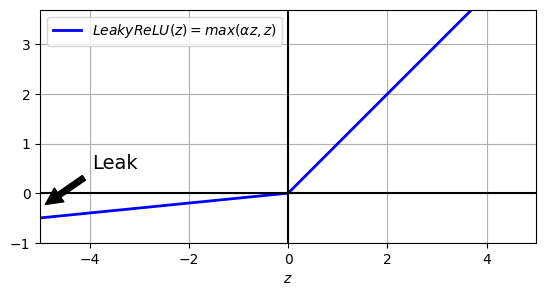

In [5]:
# extra code – this cell generates and saves Figure 11–2

def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

# Figure 11-2. Leaky ReLU: like ReLU, but with a small slope for negative values

Keras includes the classes `LeakyReLU` and `PReLU` in the `tf.keras.layers package`. Just like for other ReLU variants, you should use He initialization with these. For example:

In [6]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

If you prefer, you can also use `LeakyReLU` as a separate layer in your model; it makes no difference for training and predictions:

In [7]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

For PReLU, replace `LeakyReLU` with `PReLU`. There is currently no official implementation of RReLU in Keras, but you can fairly easily implement your own (to learn how to do that, see the exercises at the end of Chapter 12).

ReLU, leaky ReLU, and PReLU all suffer from the fact that they are not smooth functions: their derivatives abruptly change (at $z = 0$). As we saw in Chapter 4 when we discussed lasso, this sort of discontinuity can make gradient descent bounce around the optimum, and slow down convergence. So now we will look at some smooth variants of the ReLU activation function, starting with ELU and SELU.

# ELU AND SELU
In 2015, a paper by Djork-Arné Clevert et al. proposed a new activation function, called the exponential linear unit (ELU), that outperformed all the ReLU variants in the authors’ experiments: training time was reduced, and the neural network performed better on the test set. Equation 11-2 shows this activation function’s definition.

In [9]:
dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

In [10]:
dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

Equation 11-2. ELU activation function

$ELU_\alpha(z) = \begin{cases} \alpha (e^z - 1) & \text{if } z < 0 \\ z & \text{if } z \ge 0 \end{cases}$

Where:
$e^z$ is $exp(z)$


The ELU activation function looks a lot like the ReLU function (see Figure 11-3), with a few major differences:

- It takes on negative values when $z < 0$, which allows the unit to have an average output closer to 0 and helps alleviate the vanishing gradients problem. The hyperparameter $\alpha$ defines the opposite of the value that the ELU function approaches when $z$ is a large negative number. It is usually set to 1, but you can tweak it like any other hyperparameter.

- It has a nonzero gradient for $z < 0$, which avoids the dead neurons problem.

- If $\alpha$ is equal to 1 then the function is smooth everywhere, including around $z = 0$, which helps speed up gradient descent since it does not bounce as much to the left and right of $z = 0$.

Using ELU with Keras is as easy as setting `activation="elu"`, and like with other ReLU variants, you should use He initialization. The main drawback of the ELU activation function is that it is slower to compute than the ReLU function and its variants (due to the use of the exponential function). Its faster convergence rate during training may compensate for that slow computation, but still, at test time an ELU network will be a bit slower than a ReLU network.

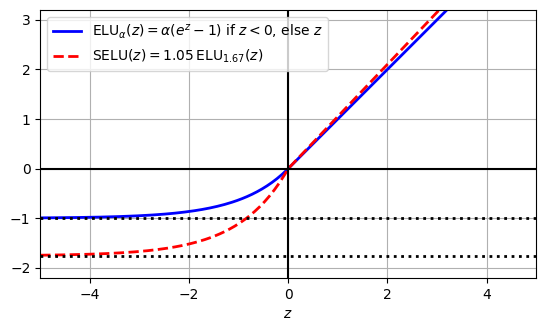

In [8]:
# extra code – this cell generates and saves Figure 11–3

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

plt.show()
# Figure 11-3. ELU and SELU activation functions

Not long after, a 2017 paper by Günter Klambauer et al. introduced the scaled ELU (SELU) activation function: as its name suggests, it is a scaled variant of the ELU activation function (about 1.05 times ELU, using $\alpha$ ≈ 1.67). The authors showed that if you build a neural network composed exclusively of a stack of dense layers (i.e., an MLP), and if all hidden layers use the SELU activation function, then the network will self-normalize: the output of each layer will tend to preserve a mean of 0 and a standard deviation of 1 during training, which solves the vanishing/exploding gradients problem. As a result, the SELU activation function may outperform other activation functions for MLPs, especially deep ones. To use it with Keras, just set `activation="selu"`. There are, however, a few conditions for self-normalization to happen (see the paper for the mathematical justification):

- The input features must be standardized: mean 0 and standard deviation 1.

- Every hidden layer’s weights must be initialized using LeCun normal initialization. In Keras, this means setting `kernel_initializer="lecun_normal"`.

- The self-normalizing property is only guaranteed with plain MLPs. If you try to use SELU in other architectures, like recurrent networks (see Chapter 15) or networks with skip connections (i.e., connections that skip layers, such as in Wide & Deep nets), it will probably not outperform ELU.

- You cannot use regularization techniques like $\ell_1$ or $\ell_2$ regularization, max-norm, batch-norm, or regular dropout (these are discussed later in this chapter).

These are significant constraints, so despite its promises, SELU did not gain a lot of traction. Moreover, three more activation functions seem to outperform it quite consistently on most tasks: GELU, Swish, and Mish.

**Extra material – an example of a self-regularized network using SELU**

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [11]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [12]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's train it. Do not foget to scale the inputs to mean 0 and standard deviation 1:

In [13]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [14]:

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [15]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [16]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 18s 8ms/step - loss: 1.1683 - accuracy: 0.5488 - val_loss: 0.8493 - val_accuracy: 0.6850
Epoch 2/5
1719/1719 [==============================] - 13s 8ms/step - loss: 0.7129 - accuracy: 0.7410 - val_loss: 0.6523 - val_accuracy: 0.7772
Epoch 3/5
1719/1719 [==============================] - 13s 7ms/step - loss: 0.6079 - accuracy: 0.7843 - val_loss: 0.6777 - val_accuracy: 0.7744
Epoch 4/5
1719/1719 [==============================] - 13s 8ms/step - loss: 0.5588 - accuracy: 0.8087 - val_loss: 0.5181 - val_accuracy: 0.8186
Epoch 5/5
1719/1719 [==============================] - 13s 7ms/step - loss: 0.4895 - accuracy: 0.8344 - val_loss: 0.4926 - val_accuracy: 0.8278


The network managed to learn, despite how deep it is. Now look at what happens if we try to use the ReLU activation function instead:

In [17]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [18]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [19]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 16s 7ms/step - loss: 1.9607 - accuracy: 0.2120 - val_loss: 1.4124 - val_accuracy: 0.4124
Epoch 2/5
1719/1719 [==============================] - 10s 6ms/step - loss: 1.2951 - accuracy: 0.4245 - val_loss: 1.1893 - val_accuracy: 0.4914
Epoch 3/5
1719/1719 [==============================] - 10s 6ms/step - loss: 1.0947 - accuracy: 0.5370 - val_loss: 1.9116 - val_accuracy: 0.2222
Epoch 4/5
1719/1719 [==============================] - 10s 6ms/step - loss: 1.0085 - accuracy: 0.5852 - val_loss: 0.8300 - val_accuracy: 0.7044
Epoch 5/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.8266 - accuracy: 0.6871 - val_loss: 0.8722 - val_accuracy: 0.6810


Not great at all, we suffered from the vanishing/exploding gradients problem.

# GELU, SWISH, AND MISH
GELU was introduced in a 2016 paper by Dan Hendrycks and Kevin Gimpel. Once again, you can think of it as a smooth variant of the ReLU activation function. Its definition is given in Equation 11-3, where $\Phi$ is the standard Gaussian cumulative distribution function (CDF): $\Phi(z)$ corresponds to the probability that a value sampled randomly from a normal distribution of mean 0 and variance 1 is lower than $z$.


Equation 11-3. GELU activation function

$$GELU(z) = z \Phi(z)$$

As you can see in Figure 11-4, GELU resembles ReLU: it approaches 0 when its input $z$ is very negative, and it approaches $z$ when $z$ is very positive. However, whereas all the activation functions we’ve discussed so far were both convex and monotonic, the GELU activation function is neither: from left to right, it starts by going straight, then it wiggles down, reaches a low point around –0.17 (near $z \approx –0.75$), and finally bounces up and ends up going straight toward the top right. This fairly complex shape and the fact that it has a curvature at every point may explain why it works so well, especially for complex tasks: gradient descent may find it easier to fit complex patterns. In practice, it often outperforms every other activation function discussed so far. However, it is a bit more computationally intensive, and the performance boost it provides is not always sufficient to justify the extra cost. That said, it is possible to show that it is approximately equal to $z \sigma(1.702 z)$, where $\sigma$ is the sigmoid function: using this approximation also works very well, and it has the advantage of being much faster to compute.


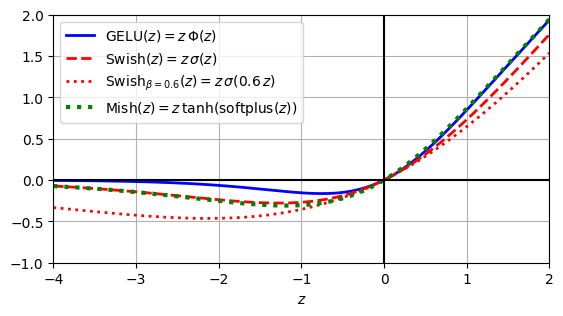

In [20]:
# extra code – this cell generates and saves Figure 11–4

def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

plt.show()
# Figure 11-4. GELU, Swish, parametrized Swish, and Mish activation functions

The GELU paper also introduced the sigmoid linear unit (SiLU) activation function, which is equal to $z \sigma(z)$, but it was outperformed by GELU in the authors’ tests. Interestingly, a 2017 paper by Prajit Ramachandran et al. rediscovered the SiLU function by automatically searching for good activation functions. The authors named it Swish, and the name caught on. In their paper, Swish outperformed every other function, including GELU. Ramachandran et al. later generalized Swish by adding an extra hyperparameter $\beta$ to scale the sigmoid function’s input. The generalized Swish function is $\text{Swish}_\beta(z) = z \sigma(\beta z)$, so GELU is approximately equal to the generalized Swish function using $\beta = 1.702$. You can tune $\beta$ like any other hyperparameter. Alternatively, it’s also possible to make $\beta$ trainable and let gradient descent optimize it: much like PReLU, this can make your model more powerful, but it also runs the risk of overfitting the data.

Another quite similar activation function is Mish, which was introduced in a 2019 paper by Diganta Misra. It is defined as $\text{mish}(z) = z \tanh(\text{softplus}(z))$, where $\text{softplus}(z) = \log(1 + \exp(z))$. Just like GELU and Swish, it is a smooth, nonconvex, and nonmonotonic variant of ReLU, and once again the author ran many experiments and found that Mish generally outperformed other activation functions—even Swish and GELU, by a tiny margin. Figure 11-4 shows GELU, Swish (both with the default $\beta = 1$ and with $\beta = 0.6$), and lastly Mish. As you can see, Mish overlaps almost perfectly with Swish when $z$ is negative, and almost perfectly with GELU when $z$ is positive.


TIP

So, which activation function should you use for the hidden layers of your deep neural networks? ReLU remains a good default for simple tasks: it’s often just as good as the more sophisticated activation functions, plus it’s very fast to compute, and many libraries and hardware accelerators provide ReLU-specific optimizations. However, Swish is probably a better default for more complex tasks, and you can even try parametrized Swish with a learnable $\beta$ parameter for the most complex tasks. Mish may give you slightly better results, but it requires a bit more compute. If you care a lot about runtime latency, then you may prefer leaky ReLU, or parametrized leaky ReLU for more complex tasks. For deep MLPs, give SELU a try, but make sure to respect the constraints listed earlier. If you have spare time and computing power, you can use cross-validation to evaluate other activation functions as well.


Keras supports GELU and Swish out of the box; just use `activation="gelu"` or `activation="swish"`. However, it does not support Mish or the generalized Swish activation function yet (but see Chapter 12 to see how to implement your own activation functions and layers).

That’s all for activation functions! Now, let’s look at a completely different way to solve the unstable gradients problem: batch normalization.

# BATCH NORMALIZATION
Although using He initialization along with ReLU (or any of its variants) can significantly reduce the danger of the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training.

In a 2015 paper, Sergey Ioffe and Christian Szegedy proposed a technique called batch normalization (BN) that addresses these problems. The technique consists of adding an operation in the model just before or after the activation function of each hidden layer. This operation simply zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting. In other words, the operation lets the model learn the optimal scale and mean of each of the layer’s inputs. In many cases, if you add a BN layer as the very first layer of your neural network, you do not need to standardize your training set. That is, there’s no need for `StandardScaler` or `Normalization`; the BN layer will do it for you (well, approximately, since it only looks at one batch at a time, and it can also rescale and shift each input feature).

In order to zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation. It does so by evaluating the mean and standard deviation of the input over the current mini-batch (hence the name “batch normalization”). The whole operation is summarized step by step in Equation 11-4.

In [ ]:
# todo: From the authors  notebook it is not clar if if x is x or X. Check it in physical book

Equation 11-4. Batch normalization algorithm

$1. \mu_B = \frac{1}{m_B} \sum_{i=1}^{m_B} x^{(i)}$\
$2. \sigma_B^2 = \frac{1}{m_B} \sum_{i=1}^{m_B} (x^{(i)} - \mu_B)^2$\
$3. \hat{x}^{(i)} = \frac{x^{(i)} - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$\
$4. z^{(i)} = \gamma \otimes \hat{x}^{(i)} + \beta$\
Where:
- $\mu_B$ is the vector of input means, evaluated over the whole mini-batch $B$ (it contains one mean per input).

- $m_B$ is the number of instances in the mini-batch.

- $\sigma_B$ is the vector of input standard deviations, also evaluated over the whole mini-batch (it contains one standard deviation per input).

- $\hat{x}^{(i)}$ is the vector of zero-centered and normalized inputs for instance $i$.

- $\varepsilon$ is a tiny number that avoids division by zero and ensures the gradients don’t grow too large (typically $10^{-5}$). This is called a smoothing term.

- $\gamma$ is the output scale parameter vector for the layer (it contains one scale parameter per input).

- $\otimes$ represents element-wise multiplication (each input is multiplied by its corresponding output scale parameter).

- $\beta$ is the output shift (offset) parameter vector for the layer (it contains one offset parameter per input). Each input is offset by its corresponding shift parameter.

- $z^{(i)}$ is the output of the BN operation. It is a rescaled and shifted version of the inputs.

So during training, BN standardizes its inputs, then rescales and offsets them. Good! What about at test time? Well, it’s not that simple. Indeed, we may need to make predictions for individual instances rather than for batches of instances: in this case, we will have no way to compute each input’s mean and standard deviation. Moreover, even if we do have a batch of instances, it may be too small, or the instances may not be independent and identically distributed, so computing statistics over the batch instances would be unreliable. One solution could be to wait until the end of training, then run the whole training set through the neural network and compute the mean and standard deviation of each input of the BN layer. These “final” input means and standard deviations could then be used instead of the batch input means and standard deviations when making predictions. However, most implementations of batch normalization estimate these final statistics during training by using a moving average of the layer’s input means and standard deviations. This is what Keras does automatically when you use the `BatchNormalization` layer. To sum up, four parameter vectors are learned in each batch-normalized layer: $\gamma$ (the output scale vector) and $\beta$ (the output offset vector) are learned through regular backpropagation, and $\mu$ (the final input mean vector) and $\sigma$ (the final input standard deviation vector) are estimated using an exponential moving average. Note that $\mu$ and $\sigma$ are estimated during training, but they are used only after training (to replace the batch input means and standard deviations in Equation 11-4).

Ioffe and Szegedy demonstrated that batch normalization considerably improved all the deep neural networks they experimented with, leading to a huge improvement in the ImageNet classification task (ImageNet is a large database of images classified into many classes, commonly used to evaluate computer vision systems). The vanishing gradients problem was strongly reduced, to the point that they could use saturating activation functions such as the tanh and even the sigmoid activation function. The networks were also much less sensitive to the weight initialization. The authors were able to use much larger learning rates, significantly speeding up the learning process. Specifically, they note that:

- Applied to a state-of-the-art image classification model, batch normalization achieves the same accuracy with 14 times fewer training steps, and beats the original model by a significant margin. [...] Using an ensemble of batch-normalized networks, we improve upon the best published result on ImageNet classification: reaching 4.9% top-5 validation error (and 4.8% test error), exceeding the accuracy of human raters.

Finally, like a gift that keeps on giving, batch normalization acts like a regularizer, reducing the need for other regularization techniques (such as dropout, described later in this chapter).

Batch normalization does, however, add some complexity to the model (although it can remove the need for normalizing the input data, as discussed earlier). Moreover, there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at each layer. Fortunately, it’s often possible to fuse the BN layer with the previous layer after training, thereby avoiding the runtime penalty. This is done by updating the previous layer’s weights and biases so that it directly produces outputs of the appropriate scale and offset. For example, if the previous layer computes $XW + b$, then the BN layer will compute $\gamma \otimes (XW + b – \mu) / \sigma + \beta$ (ignoring the smoothing term $\varepsilon$ in the denominator). If we define $W' = \gamma\otimes W / \sigma$ and $b' = \gamma \otimes (b – \mu) / \sigma + \beta$, the equation simplifies to $XW' + b'$. So, if we replace the previous layer’s weights and biases ($W$ and $b$) with the updated weights and biases ($W'$ and $b'$), we can get rid of the BN layer (TFLite’s converter does this automatically; see Chapter 19).


NOTE
You may find that training is rather slow, because each epoch takes much more time when you use batch normalization. This is usually counterbalanced by the fact that convergence is much faster with BN, so it will take fewer epochs to reach the same performance. All in all, wall time will usually be shorter (this is the time measured by the clock on your wall).

# IMPLEMENTING BATCH NORMALIZATION WITH KERAS
As with most things with Keras, implementing batch normalization is straightforward and intuitive.Just add a `BatchNormalization` layer before or after each hidden layer’s activation function.You may also add a BN layer as the first layer in your model, but a plain `Normalization` layer generally performs just as well in this location (its only drawback is that you must first call its `adapt()` method).For example, this model applies BN after every hidden layer and as the first layer in the model (after flattening the input images):

In [21]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

That’s all! In this tiny example with just two hidden layers batch normalization is unlikely to have a large impact, but for deeper networks it can make a tremendous difference.

Let’s display the model summary:

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)               4

As you can see, each BN layer adds four parameters per input: $\gamma$, $\beta$, $\mu$, and $\sigma$ (for example, the first BN layer adds 3,136 parameters, which is $4 \times 784$). The last two parameters, $\mu$ and $\sigma$, are the moving averages; they are not affected by backpropagation, so Keras calls them “non-trainable” (if you count the total number of BN parameters, 3,136 + 1,200 + 400, and divide by 2, you get 2,368, which is the total number of non-trainable parameters in this model).

Let’s look at the parameters of the first BN layer. Two are trainable (by backpropagation), and two are not:


In [24]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [25]:
# extra code – just show that the model works!
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5547 - accuracy: 0.8070 - val_loss: 0.4025 - val_accuracy: 0.8536
Epoch 2/2
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4062 - accuracy: 0.8538 - val_loss: 0.3588 - val_accuracy: 0.8672


The authors of the BN paper argued in favor of adding the BN layers before the activation functions, rather than after (as we just did). There is some debate about this, as which is preferable seems to depend on the task—you can experiment with this too to see which option works best on your dataset. To add the BN layers before the activation function, you must remove the activation functions from the hidden layers and add them as separate layers after the BN layers. Moreover, since a batch normalization layer includes one offset parameter per input, you can remove the bias term from the previous layer by passing `use_bias=False` when creating it. Lastly, you can usually drop the first BN layer to avoid sandwiching the first hidden layer between two BN layers. The updated code looks like this:

In [26]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [28]:
# extra code – just show that the model works!
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 3s 1ms/step - loss: 0.6092 - accuracy: 0.7969 - val_loss: 0.4339 - val_accuracy: 0.8402
Epoch 2/2
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4270 - accuracy: 0.8513 - val_loss: 0.3777 - val_accuracy: 0.8624


The `BatchNormalization` class has quite a few hyperparameters you can tweak. The defaults will usually be fine, but you may occasionally need to tweak the `momentum`. This hyperparameter is used by the `BatchNormalization` layer when it updates the exponential moving averages; given a new value $v$ (i.e., a new vector of input means or standard deviations computed over the current batch), the layer updates the running average $\hat{v}$ using the following equation:
$$\hat{v} \leftarrow \hat{v} \times \text{momentum} + v \times (1 - \text{momentum})$$
A good momentum value is typically close to 1; for example, 0.9, 0.99, or 0.999. You want more 9s for larger datasets and for smaller mini-batches.

Another important hyperparameter is `axis`: it determines which axis should be normalized. It defaults to –1, meaning that by default it will normalize the last axis (using the means and standard deviations computed across the other axes). When the input batch is 2D (i.e., the batch shape is [batch size, features]), this means that each input feature will be normalized based on the mean and standard deviation computed across all the instances in the batch. For example, the first BN layer in the previous code example will independently normalize (and rescale and shift) each of the 784 input features. If we move the first BN layer before the `Flatten` layer, then the input batches will be 3D, with shape [batch size, height, width]; therefore, the BN layer will compute 28 means and 28 standard deviations (1 per column of pixels, computed across all instances in the batch and across all rows in the column), and it will normalize all pixels in a given column using the same mean and standard deviation. There will also be just 28 scale parameters and 28 shift parameters. If instead you still want to treat each of the 784 pixels independently, then you should set `axis=[1, 2]`.

Batch normalization has become one of the most-used layers in deep neural networks, especially deep convolutional neural networks discussed in (Chapter 14), to the point that it is often omitted in the architecture diagrams: it is assumed that BN is added after every layer. Now let’s look at one last technique to stabilize gradients during training: gradient clipping.

# GRADIENT CLIPPING
Another technique to mitigate the exploding gradients problem is to clip the gradients during backpropagation so that they never exceed some threshold. This is called gradient clipping. This technique is generally used in recurrent neural networks, where using batch normalization is tricky (as you will see in Chapter 15).

In Keras, implementing gradient clipping is just a matter of setting the `clipvalue` or `clipnorm` argument when creating an optimizer, like this:

In [29]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [30]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

This optimizer will clip every component of the gradient vector to a value between –1.0 and 1.0. This means that all the partial derivatives of the loss (with regard to each and every trainable parameter) will be clipped between –1.0 and 1.0. The threshold is a hyperparameter you can tune. Note that it may change the orientation of the gradient vector. For instance, if the original gradient vector is [0.9, 100.0], it points mostly in the direction of the second axis; but once you clip it by value, you get [0.9, 1.0], which points roughly at the diagonal between the two axes. In practice, this approach works well. If you want to ensure that gradient clipping does not change the direction of the gradient vector, you should clip by norm by setting `clipnorm` instead of `clipvalue`. This will clip the whole gradient if its $\ell_2$ norm is greater than the threshold you picked. For example, if you set `clipnorm=1.0`, then the vector [0.9, 100.0] will be clipped to [0.00899964, 0.9999595], preserving its orientation but almost eliminating the first component. If you observe that the gradients explode during training (you can track the size of the gradients using TensorBoard), you may want to try clipping by value or clipping by norm, with different thresholds, and see which option performs best on the validation set.

# REUSING PRETRAINED LAYERS
It is generally not a good idea to train a very large DNN from scratch without first trying to find an existing neural network that accomplishes a similar task to the one you are trying to tackle (I will discuss how to find them in Chapter 14). If you find such as neural network, then you can generally reuse most of its layers, except for the top ones. This technique is called transfer learning. It will not only speed up training considerably, but also requires significantly less training data.

Suppose you have access to a DNN that was trained to classify pictures into 100 different categories, including animals, plants, vehicles, and everyday objects, and you now want to train a DNN to classify specific types of vehicles. These tasks are very similar, even partly overlapping, so you should try to reuse parts of the first network (see Figure 11-5).

NOTE
If the input pictures for your new task don’t have the same size as the ones used in the original task, you will usually have to add a preprocessing step to resize them to the size expected by the original model. More generally, transfer learning will work best when the inputs have similar low-level features.

Figure 11-5. Reusing pretrained layers
![reusing_pretrained_layers](../images/reusing_pretrained_layers.png)


The output layer of the original model should usually be replaced because it is most likely not useful at all for the new task, and probably will not have the right number of outputs.

Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. You want to find the right number of layers to reuse.

TIP
The more similar the tasks are, the more layers you will want to reuse (starting with the lower layers). For very similar tasks, try to keep all the hidden layers and just replace the output layer.

Try freezing all the reused layers first (i.e., make their weights non-trainable so that gradient descent won’t modify them and they will remain fixed), then train your model and see how it performs. Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves. The more training data you have, the more layers you can unfreeze. It is also useful to reduce the learning rate when you unfreeze reused layers: this will avoid wrecking their fine-tuned weights.

If you still cannot get good performance, and you have little training data, try dropping the top hidden layer(s) and freezing all the remaining hidden layers again. You can iterate until you find the right number of layers to reuse. If you have plenty of training data, you may try replacing the top hidden layers instead of dropping them, and even adding more hidden layers.

In [ ]:
# -------------- EXTRA MATERIAL ---------------- from github

Reusing a Keras model
Let's split the fashion MNIST training set in two:

- X_train_A: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
- X_train_B: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.
The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using Dense layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 14).

In [31]:
# extra code – split Fashion MNIST into tasks A and B, then train and save
#              model A to "my_model_A".

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("saved_models/my_model_A")

Epoch 1/20
1376/1376 [==============================] - 2s 1ms/step - loss: 1.3026 - accuracy: 0.6155 - val_loss: 0.7737 - val_accuracy: 0.7631
Epoch 2/20
1376/1376 [==============================] - 1s 993us/step - loss: 0.6499 - accuracy: 0.7924 - val_loss: 0.5432 - val_accuracy: 0.8255
Epoch 3/20
1376/1376 [==============================] - 1s 989us/step - loss: 0.5090 - accuracy: 0.8388 - val_loss: 0.4561 - val_accuracy: 0.8481
Epoch 4/20
1376/1376 [==============================] - 1s 961us/step - loss: 0.4390 - accuracy: 0.8582 - val_loss: 0.4055 - val_accuracy: 0.8646
Epoch 5/20
1376/1376 [==============================] - 1s 965us/step - loss: 0.3961 - accuracy: 0.8698 - val_loss: 0.3750 - val_accuracy: 0.8737
Epoch 6/20
1376/1376 [==============================] - 1s 960us/step - loss: 0.3674 - accuracy: 0.8774 - val_loss: 0.3524 - val_accuracy: 0.8772
Epoch 7/20
1376/1376 [==============================] - 1s 1ms/step - loss: 0.3472 - accuracy: 0.8818 - val_loss: 0.3368 - val

INFO:tensorflow:Assets written to: saved_models/my_model_A\assets


In [32]:
# extra code – train and evaluate model B, without reusing model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 1s 27ms/step - loss: 0.6871 - accuracy: 0.5800 - val_loss: 0.6642 - val_accuracy: 0.6320
Epoch 2/20
7/7 [==============================] - 0s 8ms/step - loss: 0.6622 - accuracy: 0.6650 - val_loss: 0.6422 - val_accuracy: 0.6884
Epoch 3/20
7/7 [==============================] - 0s 8ms/step - loss: 0.6393 - accuracy: 0.7150 - val_loss: 0.6218 - val_accuracy: 0.7379
Epoch 4/20
7/7 [==============================] - 0s 8ms/step - loss: 0.6163 - accuracy: 0.7550 - val_loss: 0.6030 - val_accuracy: 0.7685
Epoch 5/20
7/7 [==============================] - 0s 8ms/step - loss: 0.5966 - accuracy: 0.7800 - val_loss: 0.5837 - val_accuracy: 0.8022
Epoch 6/20
7/7 [==============================] - 0s 8ms/step - loss: 0.5768 - accuracy: 0.8050 - val_loss: 0.5659 - val_accuracy: 0.8299
Epoch 7/20
7/7 [==============================] - 0s 8ms/step - loss: 0.5576 - accuracy: 0.8200 - val_loss: 0.5481 - val_accuracy: 0.8497
Epoch 8/20
7/7 [=================

[0.40009140968322754, 0.9229999780654907]

Model B reaches 91.85% accuracy on the test set. Now let's try reusing the pretrained model A.

In [ ]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that model_B_on_A and model_A actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build model_B_on_A on top of a clone of model_A:

In [34]:
tf.random.set_seed(42)  # extra code – ensure reproducibility

In [35]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [36]:
# extra code – creating model_B_on_A just like in the previous cell
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [37]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [38]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 24ms/step - loss: 0.7624 - accuracy: 0.4750 - val_loss: 0.6048 - val_accuracy: 0.5628
Epoch 2/4
7/7 [==============================] - 0s 7ms/step - loss: 0.5652 - accuracy: 0.6850 - val_loss: 0.5450 - val_accuracy: 0.7745
Epoch 3/4
7/7 [==============================] - 0s 8ms/step - loss: 0.5251 - accuracy: 0.8650 - val_loss: 0.5354 - val_accuracy: 0.8546
Epoch 4/4
7/7 [==============================] - 0s 8ms/step - loss: 0.5119 - accuracy: 0.8850 - val_loss: 0.5289 - val_accuracy: 0.8665
Epoch 1/16
7/7 [==============================] - 0s 23ms/step - loss: 0.4988 - accuracy: 0.8900 - val_loss: 0.5029 - val_accuracy: 0.8675
Epoch 2/16
7/7 [==============================] - 0s 8ms/step - loss: 0.4743 - accuracy: 0.9100 - val_loss: 0.4780 - val_accuracy: 0.8991
Epoch 3/16
7/7 [==============================] - 0s 7ms/step - loss: 0.4501 - accuracy: 0.9200 - val_loss: 0.4638 - val_accuracy: 0.8912
Epoch 4/16
7/7 [====================

In [39]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 804us/step - loss: 0.3134 - accuracy: 0.9300


[0.31335756182670593, 0.9300000071525574]

Great! We got a bit of transfer: the model's accuracy went up 2 percentage points, from 91.85% to 93.85%. This means the error rate dropped by almost 25%:

In [40]:
1 - (100 - 93.85) / (100 - 91.85)

0.24539877300613477

# Todo: seems I copied the above code and it is again in following cells. Remove it.

# TRANSFER LEARNING WITH KERAS
Let’s look at an example. Suppose the Fashion MNIST dataset only contained eight classes—for example, all the classes except for sandal and shirt. Someone built and trained a Keras model on that set and got reasonably good performance (>90% accuracy). Let’s call this model A. You now want to tackle a different task: you have images of T-shirts and pullovers, and you want to train a binary classifier: positive for T-shirts (and tops), negative for sandals. Your dataset is quite small; you only have 200 labeled images. When you train a new model for this task (let’s call it model B) with the same architecture as model A, you get 91.85% test accuracy. While drinking your morning coffee, you realize that your task is quite similar to task A, so perhaps transfer learning can help? Let’s find out!

First, you need to load model A and create a new model based on that model’s layers. You decide to reuse all the layers except for the output layer:

In [42]:
# [...]  # Assuming model A was already trained and saved to "my_model_A"
model_A = tf.keras.models.load_model("saved_models\my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that `model_A` and `model_B_on_A` now share some layers. When you train `model_B_on_A`, it will also affect `model_A`. If you want to avoid that, you need to clone `model_A` before you reuse its layers. To do this, you clone model A’s architecture with `clone_model()`, then copy its weights:

In [43]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

WARNING
`tf.keras.models.clone_model()` only clones the architecture, not the weights. If you don’t copy them manually using `set_weights()`, they will be initialized randomly when the cloned model is first used.

Now you could train `model_B_on_A` for task B, but since the new output layer was initialized randomly it will make large errors (at least during the first few epochs), so there will be large error gradients that may wreck the reused weights. To avoid this, one approach is to freeze the reused layers during the first few epochs, giving the new layer some time to learn reasonable weights. To do this, set every layer’s `trainable` attribute to `False` and compile the model:

In [44]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

NOTE
You must always compile your model after you freeze or unfreeze layers.

Now you can train the model for a few epochs, then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task B. After unfreezing the reused layers, it is usually a good idea to reduce the learning rate, once again to avoid damaging the reused weights.

In [45]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 24ms/step - loss: 5.2436 - accuracy: 0.4450 - val_loss: 4.2493 - val_accuracy: 0.4847
Epoch 2/4
7/7 [==============================] - 0s 7ms/step - loss: 4.1350 - accuracy: 0.4450 - val_loss: 3.2017 - val_accuracy: 0.4847
Epoch 3/4
7/7 [==============================] - 0s 7ms/step - loss: 3.0164 - accuracy: 0.4450 - val_loss: 2.1123 - val_accuracy: 0.4847
Epoch 4/4
7/7 [==============================] - 0s 7ms/step - loss: 1.8931 - accuracy: 0.4500 - val_loss: 1.2867 - val_accuracy: 0.4817
Epoch 1/16
7/7 [==============================] - 0s 24ms/step - loss: 1.0716 - accuracy: 0.3850 - val_loss: 0.8586 - val_accuracy: 0.4006
Epoch 2/16
7/7 [==============================] - 0s 7ms/step - loss: 0.8302 - accuracy: 0.3800 - val_loss: 0.7696 - val_accuracy: 0.3818
Epoch 3/16
7/7 [==============================] - 0s 8ms/step - loss: 0.7509 - accuracy: 0.4550 - val_loss: 0.7354 - val_accuracy: 0.4995
Epoch 4/16
7/7 [====================

So, what’s the final verdict? Well, this model’s test accuracy is 93.85%, up exactly two percentage points from 91.85%! This means that transfer learning reduced the error rate by almost 25%:

In [46]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 788us/step - loss: 0.4006 - accuracy: 0.9235


[0.40056589245796204, 0.9235000014305115]

Are you convinced? You shouldn’t be: I cheated! I tried many configurations until I found one that demonstrated a strong improvement. If you try to change the classes or the random seed, you will see that the improvement generally drops, or even vanishes or reverses. What I did is called “torturing the data until it confesses”. When a paper just looks too positive, you should be suspicious: perhaps the flashy new technique does not actually help much (in fact, it may even degrade performance), but the authors tried many variants and reported only the best results (which may be due to sheer luck), without mentioning how many failures they encountered on the way. Most of the time, this is not malicious at all, but it is part of the reason so many results in science can never be reproduced.

Why did I cheat? It turns out that transfer learning does not work very well with small dense networks, presumably because small networks learn few patterns, and dense networks learn very specific patterns, which are unlikely to be useful in other tasks. Transfer learning works best with deep convolutional neural networks, which tend to learn feature detectors that are much more general (especially in the lower layers). We will revisit transfer learning in Chapter 14, using the techniques we just discussed (and this time there will be no cheating, I promise!).

# UNSUPERVISED PRETRAINING
Suppose you want to tackle a complex task for which you don’t have much labeled training data, but unfortunately you cannot find a model trained on a similar task. Don’t lose hope! First, you should try to gather more labeled training data, but if you can’t, you may still be able to perform unsupervised pretraining (see Figure 11-6). Indeed, it is often cheap to gather unlabeled training examples, but expensive to label them. If you can gather plenty of unlabeled training data, you can try to use it to train an unsupervised model, such as an autoencoder or a generative adversarial network (GAN; see Chapter 17). Then you can reuse the lower layers of the autoencoder or the lower layers of the GAN’s discriminator, add the output layer for your task on top, and fine-tune the final network using supervised learning (i.e., with the labeled training examples).

It is this technique that Geoffrey Hinton and his team used in 2006, and which led to the revival of neural networks and the success of deep learning. Until 2010, unsupervised pretraining—typically with restricted Boltzmann machines (RBMs; see the notebook at https://homl.info/extra-anns)—was the norm for deep nets, and only after the vanishing gradients problem was alleviated did it become much more common to train DNNs purely using supervised learning. Unsupervised pretraining (today typically using autoencoders or GANs rather than RBMs) is still a good option when you have a complex task to solve, no similar model you can reuse, and little labeled training data but plenty of unlabeled training data.

Note that in the early days of deep learning it was difficult to train deep models, so people would use a technique called greedy layer-wise pretraining (depicted in Figure 11-6). They would first train an unsupervised model with a single layer, typically an RBM, then they would freeze that layer and add another one on top of it, then train the model again (effectively just training the new layer), then freeze the new layer and add another layer on top of it, train the model again, and so on. Nowadays, things are much simpler: people generally train the full unsupervised model in one shot and use autoencoders or GANs rather than RBMs.

Figure 11-6. In unsupervised training, a model is trained on all data, including the unlabeled data, using an unsupervised learning technique, then it is fine-tuned for the final task on just the labeled data using a supervised learning technique; the unsupervised part may train one layer at a time as shown here, or it may train the full model directly
![mls3_1106](../images/mls3_1106.png)

# PRETRAINING ON AN AUXILIARY TASK
If you do not have much labeled training data, one last option is to train a first neural network on an auxiliary task for which you can easily obtain or generate labeled training data, then reuse the lower layers of that network for your actual task. The first neural network’s lower layers will learn feature detectors that will likely be reusable by the second neural network.

For example, if you want to build a system to recognize faces, you may only have a few pictures of each individual—clearly not enough to train a good classifier. Gathering hundreds of pictures of each person would not be practical. You could, however, gather a lot of pictures of random people on the web and train a first neural network to detect whether or not two different pictures feature the same person. Such a network would learn good feature detectors for faces, so reusing its lower layers would allow you to train a good face classifier that uses little training data.

For natural language processing (NLP) applications, you can download a corpus of millions of text documents and automatically generate labeled data from it. For example, you could randomly mask out some words and train a model to predict what the missing words are (e.g., it should predict that the missing word in the sentence “What ___ you saying?” is probably “are” or “were”). If you can train a model to reach good performance on this task, then it will already know quite a lot about language, and you can certainly reuse it for your actual task and fine-tune it on your labeled data (we will discuss more pretraining tasks in Chapter 15).

NOTE
Self-supervised learning is when you automatically generate the labels from the data itself, as in the text-masking example, then you train a model on the resulting “labeled” dataset using supervised learning techniques.

# FASTER OPTIMIZERS
Training a very large deep neural network can be painfully slow. So far we have seen four ways to speed up training (and reach a better solution): applying a good initialization strategy for the connection weights, using a good activation function, using batch normalization, and reusing parts of a pretrained network (possibly built for an auxiliary task or using unsupervised learning). Another huge speed boost comes from using a faster optimizer than the regular gradient descent optimizer. In this section we will present the most popular optimization algorithms: momentum, Nesterov accelerated gradient, AdaGrad, RMSProp, and finally Adam and its variants.

In [47]:
# extra code – a little function to test an optimizer on Fashion MNIST

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [48]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [49]:
history_sgd = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6917 - accuracy: 0.7634 - val_loss: 0.5249 - val_accuracy: 0.8108
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4630 - accuracy: 0.8369 - val_loss: 0.4405 - val_accuracy: 0.8404
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4192 - accuracy: 0.8537 - val_loss: 0.4229 - val_accuracy: 0.8498
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3936 - accuracy: 0.8627 - val_loss: 0.3894 - val_accuracy: 0.8598
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3743 - accuracy: 0.8682 - val_loss: 0.3698 - val_accuracy: 0.8670
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3612 - accuracy: 0.8719 - val_loss: 0.3789 - val_accuracy: 0.8622
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3452 - accuracy: 0.8761 - val_loss: 0.3593 - val_accuracy:

# MOMENTUM

Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity (if there is some friction or air resistance). This is the core idea behind momentum optimization, proposed by Boris Polyak in 1964. In contrast, regular gradient descent will take small steps when the slope is gentle and big steps when the slope is steep, but it will never pick up speed. As a result, regular gradient descent is generally much slower to reach the minimum than momentum optimization.

Recall that gradient descent updates the weights $\theta$ by directly subtracting the gradient of the cost function $J(\theta)$ with regard to the weights ($\nabla_\theta J(\theta)$) multiplied by the learning rate $\eta$. The equation is $\theta \leftarrow \theta - \eta \nabla_\theta J(\theta)$. It does not care about what the earlier gradients were. If the local gradient is tiny, it goes very slowly.

Momentum optimization cares a great deal about what previous gradients were: at each iteration, it subtracts the local gradient from the momentum vector $m$ (multiplied by the learning rate $\eta$), and it updates the weights by adding this momentum vector (see Equation 11-5). In other words, the gradient is used as an acceleration, not as a speed. To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter $\beta$, called the momentum, which must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9.


Equation 11-5. Momentum algorithm
$1. \, m \leftarrow \beta m - \eta \nabla_{\theta} J(\theta)$\
$2. \, \theta \leftarrow \theta + m$

You can verify that if the gradient remains constant, the terminal velocity (i.e., the maximum size of the weight updates) is equal to that gradient multiplied by the learning rate $\eta$ multiplied by $\frac{1}{1 - \beta}$ (ignoring the sign). For example, if $\beta = 0.9$, then the terminal velocity is equal to 10 times the gradient times the learning rate, so momentum optimization ends up going 10 times faster than gradient descent! This allows momentum optimization to escape from plateaus much faster than gradient descent. We saw in Chapter 4 that when the inputs have very different scales, the cost function will look like an elongated bowl (see Figure 4-7). Gradient descent goes down the steep slope quite fast, but then it takes a very long time to go down the valley. In contrast, momentum optimization will roll down the valley faster and faster until it reaches the bottom (the optimum). In deep neural networks that don’t use batch normalization, the upper layers will often end up having inputs with very different scales, so using momentum optimization helps a lot. It can also help roll past local optima.


NOTE
Due to the momentum, the optimizer may overshoot a bit, then come back, overshoot again, and oscillate like this many times before stabilizing at the minimum. This is one of the reasons it’s good to have a bit of friction in the system: it gets rid of these oscillations and thus speeds up convergence.

Implementing momentum optimization in Keras is a no-brainer: just use the `SGD` optimizer and set its `momentum` hyperparameter, then lie back and profit!

In [50]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

The one drawback of momentum optimization is that it adds yet another hyperparameter to tune. However, the momentum value of 0.9 usually works well in practice and almost always goes faster than regular gradient descent.

In [51]:
history_momentum = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6839 - accuracy: 0.7637 - val_loss: 0.5121 - val_accuracy: 0.8188
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4664 - accuracy: 0.8371 - val_loss: 0.4404 - val_accuracy: 0.8460
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4252 - accuracy: 0.8499 - val_loss: 0.4118 - val_accuracy: 0.8550
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3985 - accuracy: 0.8594 - val_loss: 0.3819 - val_accuracy: 0.8664
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3775 - accuracy: 0.8654 - val_loss: 0.3747 - val_accuracy: 0.8652
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3641 - accuracy: 0.8696 - val_loss: 0.3707 - val_accuracy: 0.8692
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3482 - accuracy: 0.8749 - val_loss: 0.3590 - val_accuracy:

# NESTEROV ACCELERATED GRADIENT

One small variant to momentum optimization, proposed by Yurii Nesterov in 1983, is almost always faster than regular momentum optimization. The Nesterov accelerated gradient (NAG) method, also known as Nesterov momentum optimization, measures the gradient of the cost function not at the local position $\theta $ but slightly ahead in the direction of the momentum, at $\theta + \beta m $ (see Equation 11-6).


Equation 11-6. Nesterov accelerated gradient algorithm
$1. \, m \leftarrow \beta m - \eta \nabla_{\theta} J(\theta + \beta m)$\
$2. \, \theta \leftarrow \theta + m$
This small tweak works because in general the momentum vector will be pointing in the right direction (i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than the gradient at the original position, as you can see in Figure 11-7 (where $\nabla_1$ represents the gradient of the cost function measured at the starting point $\theta$, and $\nabla_2$ represents the gradient at the point located at $\theta + \beta m$).


Figure 11-7. Regular versus Nesterov momentum optimization: the former applies the gradients computed before the momentum step, while the latter applies the gradients computed after
![regular_vs_nesterov_momentum](../images/regular_vs_nesterov_momentum.png)

As you can see, the Nesterov update ends up closer to the optimum. After a while, these small improvements add up and NAG ends up being significantly faster than regular momentum optimization. Moreover, note that when the momentum pushes the weights across a valley, $\nabla_1$ continues to push farther across the valley, while $\nabla_2$ pushes back toward the bottom of the valley. This helps reduce oscillations and thus NAG converges faster.

To use NAG, simply set `nesterov=True` when creating the `SGD` optimizer:


In [52]:
optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.001,
    momentum=0.9,
    nesterov=True
)

In [53]:
history_nesterov = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6800 - accuracy: 0.7668 - val_loss: 0.4971 - val_accuracy: 0.8252
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4573 - accuracy: 0.8388 - val_loss: 0.4402 - val_accuracy: 0.8388
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4127 - accuracy: 0.8537 - val_loss: 0.4028 - val_accuracy: 0.8550
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3854 - accuracy: 0.8629 - val_loss: 0.3807 - val_accuracy: 0.8608
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3645 - accuracy: 0.8701 - val_loss: 0.3666 - val_accuracy: 0.8642
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3504 - accuracy: 0.8743 - val_loss: 0.3744 - val_accuracy: 0.8660
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3354 - accuracy: 0.8786 - val_loss: 0.3702 - val_accuracy:

# ADAGRAD
Consider the elongated bowl problem again: gradient descent starts by quickly going down the steepest slope, which does not point straight toward the global optimum, then it very slowly goes down to the bottom of the valley. It would be nice if the algorithm could correct its direction earlier to point a bit more toward the global optimum. The AdaGrad algorithm achieves this correction by scaling down the gradient vector along the steepest dimensions (see Equation 11-7).

Equation 11-7. AdaGrad algorithm
$1. \, s \leftarrow s + \nabla_{\theta} J(\theta) \otimes \nabla_{\theta} J(\theta)$\
$2. \, \theta \leftarrow \theta - \eta \nabla_{\theta} J(\theta) \oslash \sqrt{s + \varepsilon}$

The first step accumulates the square of the gradients into the vector $s$ (recall that the $\otimes$ symbol represents the element-wise multiplication). This vectorized form is equivalent to computing $s_i \leftarrow s_i + \left( \frac{\partial J(\theta)}{\partial \theta_i} \right)^2$ for each element $s_i$ of the vector $s$; in other words, each $s_i$ accumulates the squares of the partial derivative of the cost function with regard to parameter $\theta_i$. If the cost function is steep along the $i^{th}$ dimension, then $s_i$ will get larger and larger at each iteration.

The second step is almost identical to gradient descent, but with one big difference: the gradient vector is scaled down by a factor of $\sqrt{s + \varepsilon}$ (the $\oslash$ symbol represents the element-wise division, and $\varepsilon$ is a smoothing term to avoid division by zero, typically set to $10^{-10}$). This vectorized form is equivalent to simultaneously computing $ \theta_i \leftarrow \theta_i - \eta \partial J(\theta) / \partial \theta_i / \sqrt{s_i + \varepsilon} $ for all parameters $\theta_i$.

In short, this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an adaptive learning rate. It helps point the resulting updates more directly toward the global optimum (see Figure 11-8). One additional benefit is that it requires much less tuning of the learning rate hyperparameter $\eta$.


Figure 11-8. AdaGrad versus gradient descent: the former can correct its direction earlier to point to the optimum
![adaGrad_versus_gradient_descent](../images/adaGrad_versus_gradient_descent.png)

AdaGrad frequently performs well for simple quadratic problems, but it often stops too early when training neural networks: the learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the global optimum. So even though Keras has an `Adagrad` optimizer, you should not use it to train deep neural networks (it may be efficient for simpler tasks such as linear regression, though). Still, understanding AdaGrad is helpful to comprehend the other adaptive learning rate optimizers.

In [55]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [56]:
history_adagrad = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 1.0197 - accuracy: 0.6710 - val_loss: 0.6965 - val_accuracy: 0.7666
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6453 - accuracy: 0.7827 - val_loss: 0.5921 - val_accuracy: 0.8024
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5748 - accuracy: 0.8076 - val_loss: 0.5451 - val_accuracy: 0.8176
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5378 - accuracy: 0.8195 - val_loss: 0.5182 - val_accuracy: 0.8246
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5132 - accuracy: 0.8273 - val_loss: 0.4982 - val_accuracy: 0.8290
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4959 - accuracy: 0.8319 - val_loss: 0.4864 - val_accuracy: 0.8332
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4827 - accuracy: 0.8360 - val_loss: 0.4732 - val_accuracy:

# RMSProp
As we’ve seen, AdaGrad runs the risk of slowing down a bit too fast and never converging to the global optimum. The RMSProp algorithm fixes this by accumulating only the gradients from the most recent iterations, as opposed to all the gradients since the beginning of training. It does so by using exponential decay in the first step (see Equation 11-8).

Equation 11-8. RMSProp algorithm
$1. \, s \leftarrow \rho s + (1 - \rho) \nabla_{\theta} J(\theta) \otimes \nabla_{\theta} J(\theta)$\
$2. \, \theta \leftarrow \theta - \eta \nabla_{\theta} J(\theta) \oslash \sqrt{s + \varepsilon}$

The decay rate $\rho$ is typically set to 0.9. Yes, it is once again a new hyperparameter, but this default value often works well, so you may not need to tune it at all.

As you might expect, Keras has an `RMSprop` optimizer:

In [57]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [58]:
history_rmsprop = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5182 - accuracy: 0.8109 - val_loss: 0.4246 - val_accuracy: 0.8382
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3944 - accuracy: 0.8558 - val_loss: 0.4791 - val_accuracy: 0.8314
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3662 - accuracy: 0.8682 - val_loss: 0.3891 - val_accuracy: 0.8638
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3609 - accuracy: 0.8739 - val_loss: 0.3809 - val_accuracy: 0.8656
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3554 - accuracy: 0.8759 - val_loss: 0.4009 - val_accuracy: 0.8674
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3526 - accuracy: 0.8775 - val_loss: 0.4115 - val_accuracy: 0.8642
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3517 - accuracy: 0.8790 - val_loss: 0.4474 - val_accuracy:

Except on very simple problems, this optimizer almost always performs much better than AdaGrad. In fact, it was the preferred optimization algorithm of many researchers until Adam optimization came around.

# ADAM
Adam, which stands for adaptive moment estimation, combines the ideas of momentum optimization and RMSProp: just like momentum optimization, it keeps track of an exponentially decaying average of past gradients; and just like RMSProp, it keeps track of an exponentially decaying average of past squared gradients (see Equation 11-9). These are estimations of the mean and (uncentered) variance of the gradients. The mean is often called the first moment while the variance is often called the second moment, hence the name of the algorithm.

Equation 11-9. Adam algorithm
$1. \, m \leftarrow \beta_1 m - (1 - \beta_1) \nabla_{\theta} J(\theta)$\
$2. \, s \leftarrow \beta_2 s + (1 - \beta_2) \nabla_{\theta} J(\theta) \otimes \nabla_{\theta} J(\theta)$\
$3. \, \hat{m} \leftarrow \frac{m}{1 - \beta_1^t}$\
$4. \, \hat{s} \leftarrow \frac{s}{1 - \beta_2^t}$\
$5. \, \theta \leftarrow \theta + \eta \hat{m} \oslash \sqrt{\hat{s} + \varepsilon}$

In this equation, $t$ represents the iteration number (starting at 1).

If you just look at steps 1, 2, and 5, you will notice Adam’s close similarity to both momentum optimization and RMSProp: $\beta_1$ corresponds to $\beta$ in momentum optimization, and $\beta_2$ corresponds to $\rho$ in RMSProp. The only difference is that step 1 computes an exponentially decaying average rather than an exponentially decaying sum, but these are actually equivalent except for a constant factor (the decaying average is just $1 - \beta_1$ times the decaying sum). Steps 3 and 4 are somewhat of a technical detail: since $m$ and $s$ are initialized at 0, they will be biased toward 0 at the beginning of training, so these two steps will help boost $m$ and $s$ at the beginning of training.

The momentum decay hyperparameter $\beta_1$ is typically initialized to 0.9, while the scaling decay hyperparameter $\beta_2$ is often initialized to 0.999. As earlier, the smoothing term $\varepsilon$ is usually initialized to a tiny number such as $10^{-7}$. These are the default values for the Adam class. Here is how to create an Adam optimizer using Keras:


In [59]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)

In [60]:
history_adam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4985 - accuracy: 0.8218 - val_loss: 0.4094 - val_accuracy: 0.8454
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3737 - accuracy: 0.8633 - val_loss: 0.3943 - val_accuracy: 0.8488
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3389 - accuracy: 0.8741 - val_loss: 0.3545 - val_accuracy: 0.8722
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3162 - accuracy: 0.8838 - val_loss: 0.3286 - val_accuracy: 0.8782
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2968 - accuracy: 0.8889 - val_loss: 0.3248 - val_accuracy: 0.8778
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2817 - accuracy: 0.8952 - val_loss: 0.3325 - val_accuracy: 0.8820
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2694 - accuracy: 0.8977 - val_loss: 0.3544 - val_accuracy:

Since Adam is an adaptive learning rate algorithm, like AdaGrad and RMSProp, it requires less tuning of the learning rate hyperparameter $\eta$. You can often use the default value $\eta$ = 0.001, making Adam even easier to use than gradient descent.

TIP
If you are starting to feel overwhelmed by all these different techniques and are wondering how to choose the right ones for your task, don’t worry: some practical guidelines are provided at the end of this chapter.

Finally, three variants of Adam are worth mentioning: AdaMax, Nadam, and AdamW.

# ADAMAX
The Adam paper also introduced AdaMax. Notice that in step 2 of Equation 11-9, Adam accumulates the squares of the gradients in $s$ (with a greater weight for more recent gradients). In step 5, if we ignore $\varepsilon$ and steps 3 and 4 (which are technical details anyway), Adam scales down the parameter updates by the square root of $s$. In short Adam scales down the parameter updates by the $\ell_2$ norm of the time-decayed gradients (recall that the $\ell_2$ norm is the square root of the sum of squares).

AdaMax replaces the $\ell_2$ norm with the $\ell_\infty$ norm (a fancy way of saying the max). Specifically, it replaces step 2 in Equation 11-9 with the max $s \leftarrow max(\beta_2s, abs(\nabla_{\theta} J(\theta)))$, it drops step 4, and in step 5 it scales down the gradient updates by a factor of $s$, which is the max of the absolute value of the time-decayed gradients.

In practice, this can make AdaMax more stable than Adam, but it really depends on the dataset, and in general Adam performs better. So, this is just one more optimizer you can try if you experience problems with Adam on some task.


In [61]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [62]:
history_adamax = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5425 - accuracy: 0.8120 - val_loss: 0.4398 - val_accuracy: 0.8374
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4010 - accuracy: 0.8559 - val_loss: 0.4015 - val_accuracy: 0.8512
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3641 - accuracy: 0.8690 - val_loss: 0.3826 - val_accuracy: 0.8614
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3367 - accuracy: 0.8783 - val_loss: 0.3437 - val_accuracy: 0.8726
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3174 - accuracy: 0.8836 - val_loss: 0.3313 - val_accuracy: 0.8774
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3029 - accuracy: 0.8893 - val_loss: 0.3483 - val_accuracy: 0.8736
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2886 - accuracy: 0.8948 - val_loss: 0.3358 - val_accuracy:

# NADAM
Nadam optimization is Adam optimization plus the Nesterov trick, so it will often converge slightly faster than Adam. In his report introducing this technique, the researcher Timothy Dozat compares many different optimizers on various tasks and finds that Nadam generally outperforms Adam but is sometimes outperformed by RMSProp.

In [63]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [64]:
history_nadam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 4s 1ms/step - loss: 0.4819 - accuracy: 0.8282 - val_loss: 0.4116 - val_accuracy: 0.8404
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3666 - accuracy: 0.8665 - val_loss: 0.3867 - val_accuracy: 0.8538
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3329 - accuracy: 0.8768 - val_loss: 0.3398 - val_accuracy: 0.8766
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3102 - accuracy: 0.8864 - val_loss: 0.3535 - val_accuracy: 0.8734
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2923 - accuracy: 0.8919 - val_loss: 0.3450 - val_accuracy: 0.8704
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2785 - accuracy: 0.8969 - val_loss: 0.3667 - val_accuracy: 0.8730
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2698 - accuracy: 0.8972 - val_loss: 0.3567 - val_accuracy:

# ADAMW
AdamW is a variant of Adam that integrates a regularization technique called weight decay. Weight decay reduces the size of the model’s weights at each training iteration by multiplying them by a decay factor such as 0.99. This may remind you of $\ell_2$ regularization (introduced in Chapter 4), which also aims to keep the weights small, and indeed it can be shown mathematically that $\ell_2$ regularization is equivalent to weight decay when using SGD. However, when using Adam or its variants, $\ell_2$ regularization and weight decay are not equivalent: in practice, combining Adam with $\ell_2$ regularization results in models that often don’t generalize as well as those produced by SGD. AdamW fixes this issue by properly combining Adam with weight decay.

In [66]:
optimizer = tf.keras.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                      beta_1=0.9, beta_2=0.999)

In [67]:
history_adamw = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5030 - accuracy: 0.8195 - val_loss: 0.4532 - val_accuracy: 0.8200
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3782 - accuracy: 0.8614 - val_loss: 0.3871 - val_accuracy: 0.8524
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3426 - accuracy: 0.8735 - val_loss: 0.3330 - val_accuracy: 0.8740
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3176 - accuracy: 0.8818 - val_loss: 0.3439 - val_accuracy: 0.8768
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2995 - accuracy: 0.8883 - val_loss: 0.3285 - val_accuracy: 0.8794
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2859 - accuracy: 0.8933 - val_loss: 0.3570 - val_accuracy: 0.8750
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2750 - accuracy: 0.8966 - val_loss: 0.3313 - val_accuracy:

WARNING
Adaptive optimization methods (including RMSProp, Adam, AdaMax, Nadam, and AdamW optimization) are often great, converging fast to a good solution. However, a 2017 paper by Ashia C. Wilson et al. showed that they can lead to solutions that generalize poorly on some datasets. So when you are disappointed by your model’s performance, try using NAG instead: your dataset may just be allergic to adaptive gradients. Also check out the latest research, because it’s moving fast.

To use Nadam, AdaMax, or AdamW in Keras, replace `tf.keras.optimizers.Adam` with `tf.keras.optimizers.Nadam`, `tf.keras.optimizers.Adamax`, or `tf.keras.optimizers.experimental.AdamW`. For AdamW, you probably want to tune the `weight_decay` hyperparameter.

All the optimization techniques discussed so far only rely on the first-order partial derivatives (Jacobians). The optimization literature also contains amazing algorithms based on the second-order partial derivatives (the Hessians, which are the partial derivatives of the Jacobians). Unfortunately, these algorithms are very hard to apply to deep neural networks because there are $n^2$ Hessians per output (where $n$ is the number of parameters), as opposed to just $n$ Jacobians per output. Since DNNs typically have tens of thousands of parameters or more, the second-order optimization algorithms often don’t even fit in memory, and even when they do, computing the Hessians is just too slow.

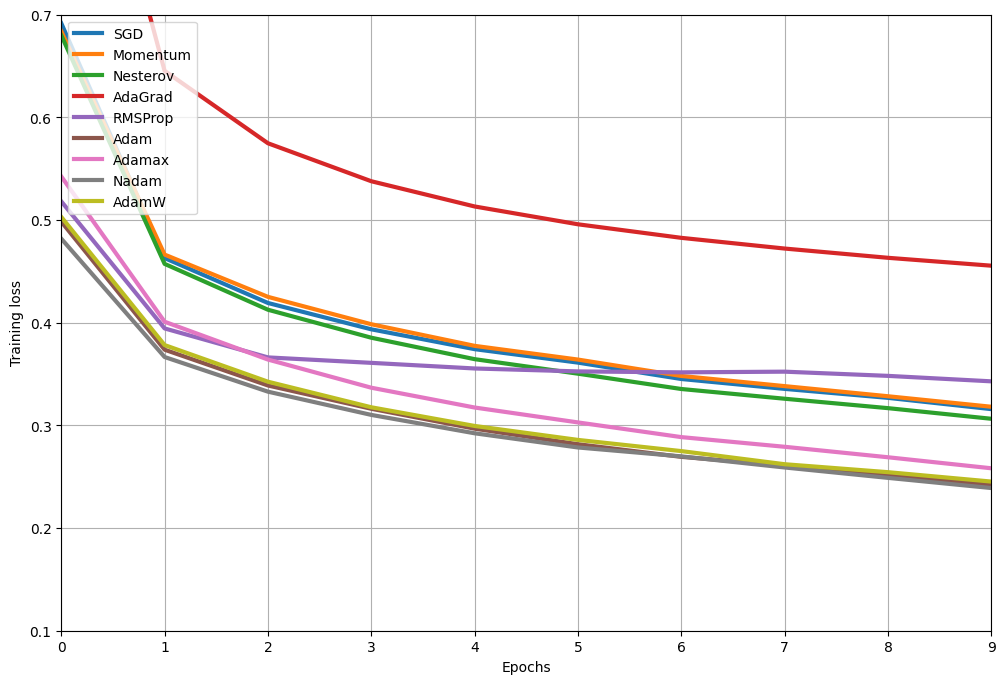

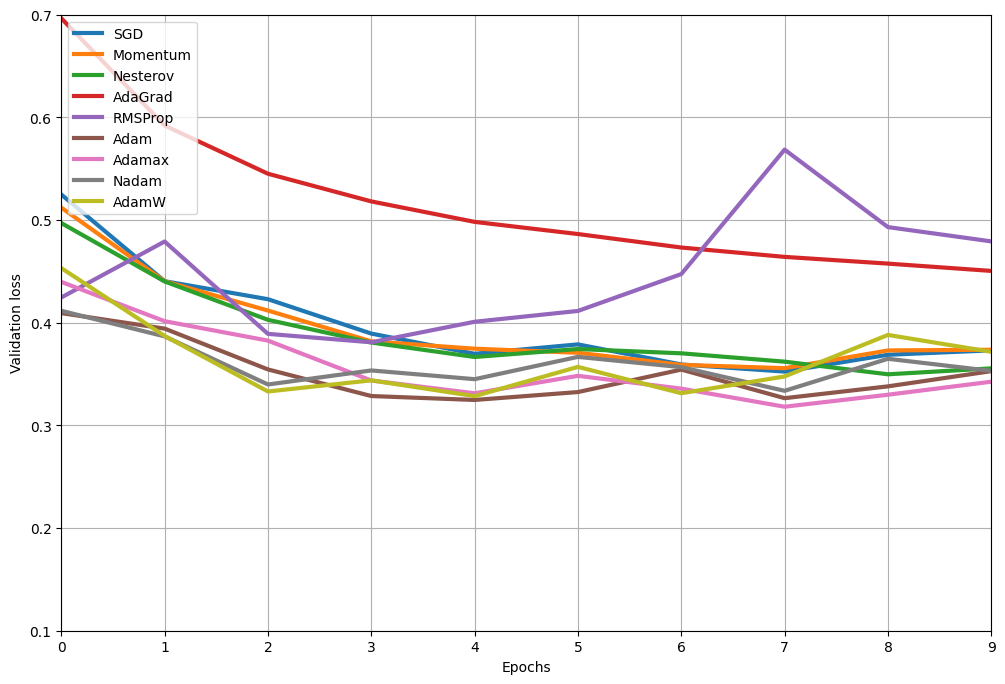

In [68]:
# extra code – visualize the learning curves of all the optimizers

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

TRAINING SPARSE MODELS
All the optimization algorithms we just discussed produce dense models, meaning that most parameters will be nonzero. If you need a blazingly fast model at runtime, or if you need it to take up less memory, you may prefer to end up with a sparse model instead.

One way to achieve this is to train the model as usual, then get rid of the tiny weights (set them to zero). However, this will typically not lead to a very sparse model, and it may degrade the model’s performance.

A better option is to apply strong $\ell_1$ regularization during training (you’ll see how later in this chapter), as it pushes the optimizer to zero out as many weights as it can (as discussed in “Lasso Regression”).

If these techniques remain insufficient, check out the TensorFlow Model Optimization Toolkit (TF-MOT), which provides a pruning API capable of iteratively removing connections during training based on their magnitude.

Table 11-2 compares all the optimizers we’ve discussed so far (* is bad, ** is average, and *** is good).

| Class                              | Convergence speed | Convergence quality |
|------------------------------------|-------------------|---------------------|
| SGD                                | *                 | ***                 |
| SGD(momentum...)                   | **                | ***                 |
| SGD(momentum=..., nesterov=True)   | **                | ***                 |
| Adagrad                            | ***               | *(stops too early)  |
| RMSprop                            | ***               | ** or ***           |
| Adam                               | ***               | ** or ***           |
| Nadam                              | ***               | ** or ***           |
| AdaMax                             | ***               | ** or ***           |
| AdamW                              | ***               | ** or ***           |


# LEARNING RATE SCHEDULING
Finding a good learning rate is very important. If you set it much too high, training may diverge (as discussed in “Gradient Descent”). If you set it too low, training will eventually converge to the optimum, but it will take a very long time. If you set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum and never really settling down. If you have a limited computing budget, you may have to interrupt training before it has converged properly, yielding a suboptimal solution (see Figure 11-9).

Figure 11-9. Learning curves for various learning rates $\eta$
![learning_curves_for_various_learning_rates](../images/learning_curves_for_various_learning_rates.png)


As discussed in Chapter 10, you can find a good learning rate by training the model for a few hundred iterations, exponentially increasing the learning rate from a very small value to a very large value, and then looking at the learning curve and picking a learning rate slightly lower than the one at which the learning curve starts shooting back up. You can then reinitialize your model and train it with that learning rate.

But you can do better than a constant learning rate: if you start with a large learning rate and then reduce it once training stops making fast progress, you can reach a good solution faster than with the optimal constant learning rate. There are many different strategies to reduce the learning rate during training. It can also be beneficial to start with a low learning rate, increase it, then drop it again. These strategies are called learning schedules (I briefly introduced this concept in Chapter 4). These are the most commonly used learning schedules:

**Power scheduling**

Set the learning rate to a function of the iteration number $t$: $\eta(t) = \frac{\eta_0}{(1 + \frac{t}{s})^c}$. The initial learning rate $\eta_0$, the power $c$ (typically set to 1), and the steps $s$ are hyperparameters. The learning rate drops at each step. After $s$ steps, the learning rate is down to $\frac{\eta_0}{2}$. After $s$ more steps it is down to $\frac{\eta_0}{3}$, then it goes down to $\frac{\eta_0}{4}$, then $\frac{\eta_0}{5}$, and so on. As you can see, this schedule first drops quickly, then more and more slowly. Of course, power scheduling requires tuning $\eta_0$ and $s$ (and possibly $c$).


In [71]:
# DEPRECATED:
# optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-4)

The InverseTimeDecay scheduler uses learning_rate = initial_learning_rate / (1 + decay_rate * step / decay_steps). If you set staircase=True, then it replaces step / decay_step with floor(step / decay_step).

In [72]:
# RECOMMENDED:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=1.0,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [73]:
history_power_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6851 - accuracy: 0.7665 - val_loss: 0.4956 - val_accuracy: 0.8224
Epoch 2/10
1719/1719 [==============================] - 2s 998us/step - loss: 0.4697 - accuracy: 0.8351 - val_loss: 0.4532 - val_accuracy: 0.8340
Epoch 3/10
1719/1719 [==============================] - 2s 992us/step - loss: 0.4241 - accuracy: 0.8501 - val_loss: 0.4108 - val_accuracy: 0.8518
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4005 - accuracy: 0.8588 - val_loss: 0.3844 - val_accuracy: 0.8606
Epoch 5/10
1719/1719 [==============================] - 2s 994us/step - loss: 0.3822 - accuracy: 0.8645 - val_loss: 0.3795 - val_accuracy: 0.8624
Epoch 6/10
1719/1719 [==============================] - 2s 988us/step - loss: 0.3680 - accuracy: 0.8675 - val_loss: 0.3838 - val_accuracy: 0.8640
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3584 - accuracy: 0.8717 - val_loss: 0.3661 - val_a

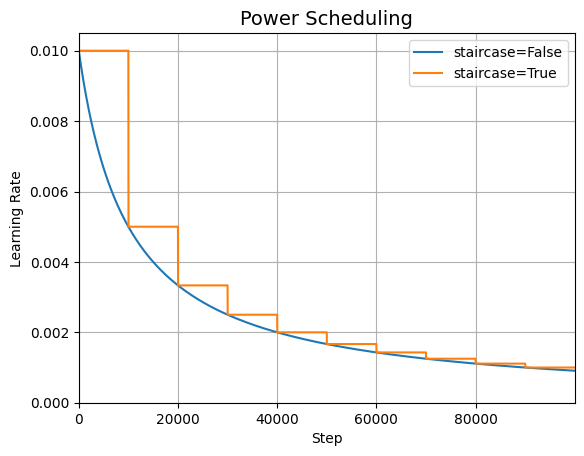

In [74]:
# extra code – this cell plots power scheduling with staircase=True or False

initial_learning_rate = 0.01
decay_rate = 1.0
decay_steps = 10_000

steps = np.arange(100_000)
lrs = initial_learning_rate / (1 + decay_rate * steps / decay_steps)
lrs2 = initial_learning_rate / (1 + decay_rate * np.floor(steps / decay_steps))

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


**Exponential scheduling**
Set the learning rate to $\eta(t) = \eta_0 \, 0.1^{\frac{t}{s}}$. The learning rate will gradually drop by a factor of 10 every $s$ steps. While power scheduling reduces the learning rate more and more slowly, exponential scheduling keeps slashing it by a factor of 10 every $s$ steps.


learning_rate = initial_learning_rate * decay_rate ** (step / decay_steps)

In [75]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20_000,
    decay_rate=0.1,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [76]:

history_exponential_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6906 - accuracy: 0.7650 - val_loss: 0.4882 - val_accuracy: 0.8330
Epoch 2/10
1719/1719 [==============================] - 2s 959us/step - loss: 0.4759 - accuracy: 0.8335 - val_loss: 0.4537 - val_accuracy: 0.8392
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4310 - accuracy: 0.8478 - val_loss: 0.4191 - val_accuracy: 0.8508
Epoch 4/10
1719/1719 [==============================] - 2s 975us/step - loss: 0.4082 - accuracy: 0.8579 - val_loss: 0.3987 - val_accuracy: 0.8566
Epoch 5/10
1719/1719 [==============================] - 2s 972us/step - loss: 0.3903 - accuracy: 0.8625 - val_loss: 0.3907 - val_accuracy: 0.8592
Epoch 6/10
1719/1719 [==============================] - 2s 975us/step - loss: 0.3779 - accuracy: 0.8676 - val_loss: 0.3934 - val_accuracy: 0.8576
Epoch 7/10
1719/1719 [==============================] - 2s 979us/step - loss: 0.3693 - accuracy: 0.8706 - val_loss: 0.3822 - val

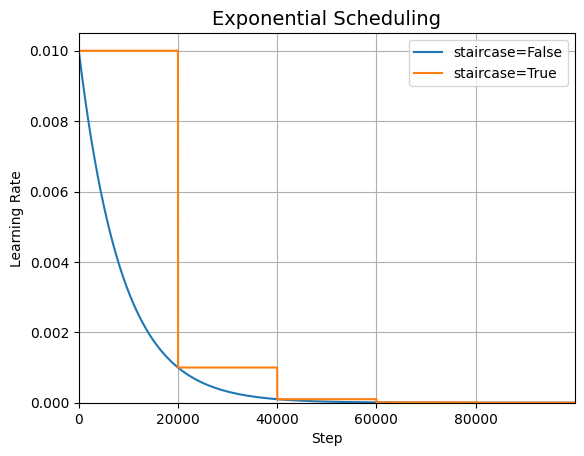

In [77]:
# extra code – this cell plots exponential scheduling

initial_learning_rate = 0.01
decay_rate = 0.1
decay_steps = 20_000

steps = np.arange(100_000)
lrs = initial_learning_rate * decay_rate ** (steps / decay_steps)
lrs2 = initial_learning_rate * decay_rate ** np.floor(steps / decay_steps)

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

Keras also provides a LearningRateScheduler callback class that lets you define your own scheduling function. Let's see how you could use it to implement exponential decay. Note that in this case the learning rate only changes at each epoch, not at each step:

In [82]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [83]:

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [84]:
# extra code – build and compile a model for Fashion MNIST

tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [85]:
n_epochs = 20

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6901 - accuracy: 0.7629 - val_loss: 0.4783 - val_accuracy: 0.8342 - lr: 0.0100
Epoch 2/20
1719/1719 [==============================] - 2s 985us/step - loss: 0.4678 - accuracy: 0.8361 - val_loss: 0.4603 - val_accuracy: 0.8354 - lr: 0.0089
Epoch 3/20
1719/1719 [==============================] - 2s 978us/step - loss: 0.4204 - accuracy: 0.8516 - val_loss: 0.4132 - val_accuracy: 0.8580 - lr: 0.0079
Epoch 4/20
1719/1719 [==============================] - 2s 989us/step - loss: 0.3963 - accuracy: 0.8605 - val_loss: 0.3882 - val_accuracy: 0.8632 - lr: 0.0071
Epoch 5/20
1719/1719 [==============================] - 2s 974us/step - loss: 0.3772 - accuracy: 0.8664 - val_loss: 0.3782 - val_accuracy: 0.8630 - lr: 0.0063
Epoch 6/20
1719/1719 [==============================] - 2s 986us/step - loss: 0.3629 - accuracy: 0.8712 - val_loss: 0.3860 - val_accuracy: 0.8612 - lr: 0.0056
Epoch 7/20
1719/1719 [==========================

Alternatively, the schedule function can take the current learning rate as a second argument:

In [86]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

If you want to use a custom scheduling function that updates the learning rate at each iteration rather than at each epoch, you can write your own callback class like this:

In [87]:
K = tf.keras.backend

class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

In [88]:
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [89]:
import math

batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])

Epoch 1/20
1719/1719 [==============================] - 3s 1ms/step - loss: 0.6993 - accuracy: 0.7614 - val_loss: 0.4852 - val_accuracy: 0.8334 - lr: 0.0089
Epoch 2/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4701 - accuracy: 0.8373 - val_loss: 0.4549 - val_accuracy: 0.8388 - lr: 0.0079
Epoch 3/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4248 - accuracy: 0.8512 - val_loss: 0.4144 - val_accuracy: 0.8572 - lr: 0.0071
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4014 - accuracy: 0.8594 - val_loss: 0.3914 - val_accuracy: 0.8596 - lr: 0.0063
Epoch 5/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3826 - accuracy: 0.8662 - val_loss: 0.3830 - val_accuracy: 0.8650 - lr: 0.0056
Epoch 6/20
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3685 - accuracy: 0.8694 - val_loss: 0.3898 - val_accuracy: 0.8644 - lr: 0.0050
Epoch 7/20
1719/1719 [==============================] - 3s

In [ ]:
# todo: Mozna nejaky bunky co jsou nize pod tema odstavcema schedulingu se budou opakovat


**Piecewise constant scheduling**
Use a constant learning rate for a number of epochs (e.g., $\eta_0 = 0.1$ for 5 epochs), then a smaller learning rate for another number of epochs (e.g., $\eta_1 = 0.001$ for 50 epochs), and so on. Although this solution can work very well, it requires fiddling around to figure out the right sequence of learning rates and how long to use each of them.


In [79]:
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[50_000, 80_000],
    values=[0.01, 0.005, 0.001]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [80]:
history_piecewise_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6794 - accuracy: 0.7681 - val_loss: 0.4733 - val_accuracy: 0.8298
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4695 - accuracy: 0.8346 - val_loss: 0.4726 - val_accuracy: 0.8284
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4220 - accuracy: 0.8504 - val_loss: 0.4130 - val_accuracy: 0.8558
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3963 - accuracy: 0.8597 - val_loss: 0.3781 - val_accuracy: 0.8638
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3748 - accuracy: 0.8661 - val_loss: 0.3729 - val_accuracy: 0.8614
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3585 - accuracy: 0.8717 - val_loss: 0.3779 - val_accuracy: 0.8644
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3461 - accuracy: 0.8741 - val_loss: 0.3634 - val_accuracy:

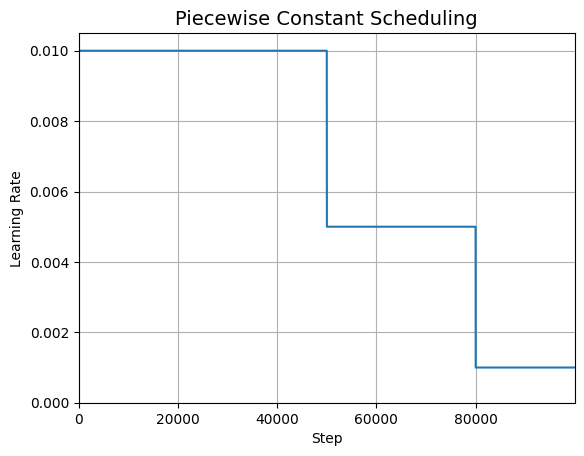

In [90]:
# extra code – this cell plots piecewise constant scheduling

boundaries = [50_000, 80_000]
values = [0.01, 0.005, 0.001]

steps = np.arange(100_000)

lrs = np.full(len(steps), values[0])
for boundary, value in zip(boundaries, values[1:]):
    lrs[boundary:] = value

plt.plot(steps, lrs, "-")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

Just like we did with exponential scheduling, we could also implement piecewise constant scheduling manually:

In [91]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [92]:
# extra code – this cell demonstrates a more general way to define
#              piecewise constant scheduling.

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [93]:
# extra code – use a tf.keras.callbacks.LearningRateScheduler like earlier

n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5458 - accuracy: 0.8066 - val_loss: 0.4910 - val_accuracy: 0.8248 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4470 - accuracy: 0.8432 - val_loss: 0.4753 - val_accuracy: 0.8210 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4319 - accuracy: 0.8483 - val_loss: 0.4893 - val_accuracy: 0.8412 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4173 - accuracy: 0.8540 - val_loss: 0.4828 - val_accuracy: 0.8380 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4062 - accuracy: 0.8578 - val_loss: 0.4134 - val_accuracy: 0.8560 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3585 - accuracy: 0.8738 - val_loss: 0.4105 - val_accuracy: 0.8574 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 2s

In [94]:
for name in sorted(dir(tf.keras.optimizers.schedules)):
    if name[0] == name[0].lower():  # must start with capital letter
        continue
    scheduler_class = getattr(tf.keras.optimizers.schedules, name)
    print(f"• {name} – {scheduler_class.__doc__.splitlines()[0]}")

• CosineDecay – A LearningRateSchedule that uses a cosine decay with optional warmup.
• CosineDecayRestarts – A LearningRateSchedule that uses a cosine decay schedule with restarts.
• ExponentialDecay – A LearningRateSchedule that uses an exponential decay schedule.
• InverseTimeDecay – A LearningRateSchedule that uses an inverse time decay schedule.
• LearningRateSchedule – The learning rate schedule base class.
• PiecewiseConstantDecay – A LearningRateSchedule that uses a piecewise constant decay schedule.
• PolynomialDecay – A LearningRateSchedule that uses a polynomial decay schedule.



**Performance scheduling**
Measure the validation error every $N$ steps (just like for early stopping), and reduce the learning rate by a factor of $\lambda$ when the error stops dropping.

In [95]:
# extra code – build and compile the model

model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [96]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6996 - accuracy: 0.7586 - val_loss: 0.4791 - val_accuracy: 0.8272 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4749 - accuracy: 0.8302 - val_loss: 0.4550 - val_accuracy: 0.8364 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4264 - accuracy: 0.8473 - val_loss: 0.4131 - val_accuracy: 0.8526 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 2s 979us/step - loss: 0.4010 - accuracy: 0.8572 - val_loss: 0.3806 - val_accuracy: 0.8654 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 2s 981us/step - loss: 0.3803 - accuracy: 0.8644 - val_loss: 0.3803 - val_accuracy: 0.8656 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 2s 988us/step - loss: 0.3637 - accuracy: 0.8694 - val_loss: 0.3888 - val_accuracy: 0.8596 - lr: 0.0100
Epoch 7/25
1719/1719 [==============================

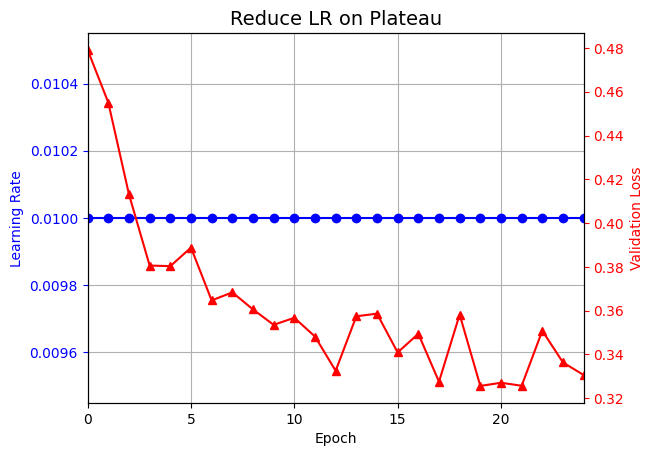

In [97]:
# extra code – this cell plots performance scheduling

plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()


**1cycle scheduling**
1cycle was introduced in a 2018 paper by Leslie Smith. Contrary to the other approaches, it starts by increasing the initial learning rate $\eta_0$, growing linearly up to $\eta_1$ halfway through training. Then it decreases the learning rate linearly down to $\eta_0$ again during the second half of training, finishing the last few epochs by dropping the rate down by several orders of magnitude (still linearly). The maximum learning rate $\eta_1$ is chosen using the same approach we used to find the optimal learning rate, and the initial learning rate $\eta_0$ is usually 10 times lower. When using a momentum, we start with a high momentum first (e.g., 0.95), then drop it down to a lower momentum during the first half of training (e.g., down to 0.85, linearly), and then bring it back up to the maximum value (e.g., 0.95) during the second half of training, finishing the last few epochs with that maximum value. Smith did many experiments showing that this approach was often able to speed up training considerably and reach better performance. For example, on the popular CIFAR10 image dataset, this approach reached 91.9% validation accuracy in just 100 epochs, compared to 90.3% accuracy in 800 epochs through a standard approach (with the same neural network architecture). This feat was dubbed super-convergence.


In [98]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

The find_learning_rate() function trains the model using the ExponentialLearningRate callback, and it returns the learning rates and corresponding batch losses. At the end, it restores the model and its optimizer to their initial state.

In [99]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The plot_lr_vs_loss() function plots the learning rates vs the losses. The optimal learning rate to use as the maximum learning rate in 1cycle is near the bottom of the curve.

In [100]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

Let's build a simple Fashion MNIST model and compile it:

In [101]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's find the optimal max learning rate for 1cycle:

430/430 [==============================] - 1s 2ms/step - loss: 1.9085 - accuracy: 0.3657


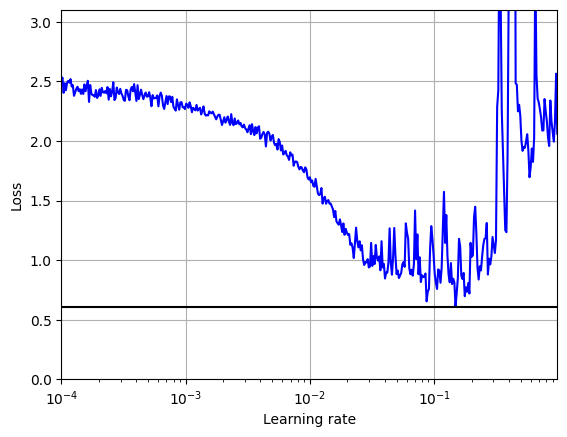

In [102]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

Looks like the max learning rate to use for 1cycle is around $10^{–1}$.

The OneCycleScheduler custom callback updates the learning rate at the beginning of each batch. It applies the logic described in the book: increase the learning rate linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.

In [103]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

Let's build and compile a simple Fashion MNIST model, then train it using the OneCycleScheduler callback:

In [104]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 1s 2ms/step - loss: 0.9814 - accuracy: 0.6789 - val_loss: 0.6054 - val_accuracy: 0.7968
Epoch 2/25
430/430 [==============================] - 1s 1ms/step - loss: 0.5778 - accuracy: 0.7983 - val_loss: 0.5116 - val_accuracy: 0.8196
Epoch 3/25
430/430 [==============================] - 1s 1ms/step - loss: 0.5023 - accuracy: 0.8239 - val_loss: 0.4599 - val_accuracy: 0.8378
Epoch 4/25
430/430 [==============================] - 1s 1ms/step - loss: 0.4570 - accuracy: 0.8383 - val_loss: 0.4497 - val_accuracy: 0.8414
Epoch 5/25
430/430 [==============================] - 1s 1ms/step - loss: 0.4281 - accuracy: 0.8482 - val_loss: 0.4067 - val_accuracy: 0.8522
Epoch 6/25
430/430 [==============================] - 1s 1ms/step - loss: 0.4017 - accuracy: 0.8553 - val_loss: 0.4678 - val_accuracy: 0.8292
Epoch 7/25
430/430 [==============================] - 1s 1ms/step - loss: 0.3871 - accuracy: 0.8601 - val_loss: 0.4005 - val_accuracy: 0.8518
Epoch 

In [ ]:
# TODO: These few cells were I guess discussed above, so check if it makes sense to delete it or keep it.


A 2013 paper by Andrew Senior et al. compared the performance of some of the most popular learning schedules when using momentum optimization to train deep neural networks for speech recognition. The authors concluded that, in this setting, both performance scheduling and exponential scheduling performed well. They favored exponential scheduling because it was easy to tune and it converged slightly faster to the optimal solution. They also mentioned that it was easier to implement than performance scheduling, but in Keras both options are easy. That said, the 1cycle approach seems to perform even better.

Implementing power scheduling in Keras is the easiest option—just set the `decay` hyperparameter when creating an optimizer:

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

The `decay` is the inverse of s (the number of steps it takes to divide the learning rate by one more unit), and Keras assumes that $c$ is equal to 1.

Exponential scheduling and piecewise scheduling are quite simple too. You first need to define a function that takes the current epoch and returns the learning rate. For example, let’s implement exponential scheduling:

In [ ]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

If you do not want to hardcode $\eta_0$ and $s$, you can create a function that returns a configured function:

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

Next, create a `LearningRateScheduler` callback, giving it the schedule function, and pass this callback to the `fit()` method:

In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, [...], callbacks=[lr_scheduler])

The `LearningRateScheduler` will update the optimizer’s `learning_rate` attribute at the beginning of each epoch. Updating the learning rate once per epoch is usually enough, but if you want it to be updated more often, for example at every step, you can always write your own callback (see the “Exponential Scheduling” section of this chapter’s notebook for an example). Updating the learning rate at every step may help if there are many steps per epoch. Alternatively, you can use the `tf.keras.optimizers.schedules` approach, described shortly.

TIP
After training, `history.history["lr"]` gives you access to the list of learning rates used during training.

The schedule function can optionally take the current learning rate as a second argument. For example, the following schedule function multiplies the previous learning rate by $0.1^\frac{1}{20}$, which results in the same exponential decay (except the decay now starts at the beginning of epoch 0 instead of 1):

In [ ]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

This implementation relies on the optimizer’s initial learning rate (contrary to the previous implementation), so make sure to set it appropriately.

When you save a model, the optimizer and its learning rate get saved along with it. This means that with this new schedule function, you could just load a trained model and continue training where it left off, no problem. Things are not so simple if your schedule function uses the `epoch` argument, however: the epoch does not get saved, and it gets reset to 0 every time you call the `fit()` method. If you were to continue training a model where it left off, this could lead to a very large learning rate, which would likely damage your model’s weights. One solution is to manually set the `fit()` method’s `initial_epoch` argument so the `epoch` starts at the right value.

For piecewise constant scheduling, you can use a schedule function like the following one (as earlier, you can define a more general function if you want; see the “Piecewise Constant Scheduling” section of the notebook for an example), then create a `LearningRateScheduler` callback with this function and pass it to the `fit()` method, just like for exponential scheduling:

In [ ]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

For performance scheduling, use the `ReduceLROnPlateau` callback. For example, if you pass the following callback to the `fit()` method, it will multiply the learning rate by 0.5 whenever the best validation loss does not improve for five consecutive epochs (other options are available; please check the documentation for more details):

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, [...], callbacks=[lr_scheduler])

Lastly, Keras offers an alternative way to implement learning rate scheduling: you can define a scheduled learning rate using one of the classes available in `tf.keras.optimizers.schedules`, then pass it to any optimizer. This approach updates the learning rate at each step rather than at each epoch. For example, here is how to implement the same exponential schedule as the `exponential_decay_fn()` function we defined earlier:

In [ ]:
import math

batch_size = 32
n_epochs = 25
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
scheduled_learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=n_steps, decay_rate=0.1)
optimizer = tf.keras.optimizers.SGD(learning_rate=scheduled_learning_rate)

This is nice and simple, plus when you save the model, the learning rate and its schedule (including its state) get saved as well.

As for 1cycle, Keras does not support it, but it’s possible to implement it in less than 30 lines of code by creating a custom callback that modifies the learning rate at each iteration. To update the optimizer’s learning rate from within the callback’s `on_batch_begin()` method, you need to call `tf.keras.backend.set_value(self.model.optimizer.learning_rate, new_learning_rate)`. See the “1Cycle Scheduling” section of the notebook for an example.

To sum up, exponential decay, performance scheduling, and 1cycle can considerably speed up convergence, so give them a try!

# AVOIDING OVERFITTING THROUGH REGULARIZATION
$\text{With four parameters I can fit an elephant and with five I can make him wiggle his trunk.}$

- John von Neumann, cited by Enrico Fermi in Nature 427

With thousands of parameters, you can fit the whole zoo. Deep neural networks typically have tens of thousands of parameters, sometimes even millions. This gives them an incredible amount of freedom and means they can fit a huge variety of complex datasets. But this great flexibility also makes the network prone to overfitting the training set. Regularization is often needed to prevent this.

We already implemented one of the best regularization techniques in Chapter 10: early stopping. Moreover, even though batch normalization was designed to solve the unstable gradients problems, it also acts like a pretty good regularizer. In this section we will examine other popular regularization techniques for neural networks: $\ell_1$ and $\ell_2$ regularization, dropout, and max-norm regularization.

# $\ell_1$ AND $\ell_2$ REGULARIZATION
Just like you did in Chapter 4 for simple linear models, you can use $\ell_2$ regularization to constrain a neural network’s connection weights, and/or $\ell_1$ regularization if you want a sparse model (with many weights equal to 0). Here is how to apply $\ell_2$ regularization to a Keras layer’s connection weights, using a regularization factor of 0.01:

In [105]:
layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))

The `l2()` function returns a regularizer that will be called at each step during training to compute the regularization loss. This is then added to the final loss. As you might expect, you can just use `tf.keras.regularizers.l1()` if you want $\ell_1$ regularization; if you want both $\ell_1$ and $\ell_2$ regularization, use `tf.keras.regularizers.l1_l2()` (specifying both regularization factors).

Since you will typically want to apply the same regularizer to all layers in your network, as well as using the same activation function and the same initialization strategy in all hidden layers, you may find yourself repeating the same arguments. This makes the code ugly and error-prone. To avoid this, you can try refactoring your code to use loops. Another option is to use Python’s `functools.partial()` function, which lets you create a thin wrapper for any callable, with some default argument values:

In [106]:
from functools import partial

tf.random.set_seed(42)  # extra code – for reproducibility
RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

In [109]:
# extra code – compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 3s 1ms/step - loss: 0.8286 - accuracy: 0.7012 - val_loss: 0.5074 - val_accuracy: 0.8268
Epoch 2/2
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5879 - accuracy: 0.7895 - val_loss: 0.4428 - val_accuracy: 0.8370


WARNING
As we saw earlier, $\ell_2$ regularization is fine when using SGD, momentum optimization, and Nesterov momentum optimization, but not with Adam and its variants. If you want to use Adam with weight decay, then do not use $\ell_2$ regularization: use AdamW instead.

# DROPOUT
Dropout is one of the most popular regularization techniques for deep neural networks. It was proposed in a paper by Geoffrey Hinton et al. in 2012 and further detailed in a 2014 paper by Nitish Srivastava et al., and it has proven to be highly successful: many state-of-the-art neural networks use dropout, as it gives them a 1%–2% accuracy boost. This may not sound like a lot, but when a model already has 95% accuracy, getting a 2% accuracy boost means dropping the error rate by almost 40% (going from 5% error to roughly 3%).

It is a fairly simple algorithm: at every training step, every neuron (including the input neurons, but always excluding the output neurons) has a probability $p$ of being temporarily “dropped out”, meaning it will be entirely ignored during this training step, but it may be active during the next step (see Figure 11-10). The hyperparameter $p$ is called the dropout rate, and it is typically set between 10% and 50%: closer to 20%–30% in recurrent neural nets (see Chapter 15), and closer to 40%–50% in convolutional neural networks (see Chapter 14). After training, neurons don’t get dropped anymore. And that’s all (except for a technical detail we will discuss momentarily).

It’s surprising at first that this destructive technique works at all. Would a company perform better if its employees were told to toss a coin every morning to decide whether or not to go to work? Well, who knows; perhaps it would! The company would be forced to adapt its organization; it could not rely on any single person to work the coffee machine or perform any other critical tasks, so this expertise would have to be spread across several people. Employees would have to learn to cooperate with many of their coworkers, not just a handful of them. The company would become much more resilient. If one person quit, it wouldn’t make much of a difference. It’s unclear whether this idea would actually work for companies, but it certainly does for neural networks. Neurons trained with dropout cannot co-adapt with their neighboring neurons; they have to be as useful as possible on their own. They also cannot rely excessively on just a few input neurons; they must pay attention to each of their input neurons. They end up being less sensitive to slight changes in the inputs. In the end, you get a more robust network that generalizes better.

Figure 11-10. With dropout regularization, at each training iteration a random subset of all neurons in one or more layers—except the output layer—are “dropped out”; these neurons output 0 at this iteration (represented by the dashed arrows)
![dropout](..\images\dropout.png)


Another way to understand the power of dropout is to realize that a unique neural network is generated at each training step. Since each neuron can be either present or absent, there are a total of $2^N$ possible networks (where $N$ is the total number of droppable neurons). This is such a huge number that it is virtually impossible for the same neural network to be sampled twice. Once you have run 10,000 training steps, you have essentially trained 10,000 different neural networks, each with just one training instance. These neural networks are obviously not independent because they share many of their weights, but they are nevertheless all different. The resulting neural network can be seen as an averaging ensemble of all these smaller neural networks.

TIP
In practice, you can usually apply dropout only to the neurons in the top one to three layers (excluding the output layer).

There is one small but important technical detail. Suppose $p = 75$%: on average only 25% of all neurons are active at each step during training. This means that after training, a neuron would be connected to four times as many input neurons as it would be during training. To compensate for this fact, we need to multiply each neuron’s input connection weights by four during training. If we don’t, the neural network will not perform well as it will see different data during and after training. More generally, we need to divide the connection weights by the keep probability $(1 – p)$ during training.

To implement dropout using Keras, you can use the `tf.keras.layers.Dropout` layer. During training, it randomly drops some inputs (setting them to 0) and divides the remaining inputs by the keep probability. After training, it does nothing at all; it just passes the inputs to the next layer. The following code applies dropout regularization before every dense layer, using a dropout rate of 0.2:

In [110]:
tf.random.set_seed(42)  # extra code – for reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])


In [111]:
# extra code – compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.6773 - accuracy: 0.7517 - val_loss: 0.4647 - val_accuracy: 0.8240
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5121 - accuracy: 0.8130 - val_loss: 0.4203 - val_accuracy: 0.8376
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4767 - accuracy: 0.8254 - val_loss: 0.3864 - val_accuracy: 0.8554
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4525 - accuracy: 0.8334 - val_loss: 0.3880 - val_accuracy: 0.8550
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4366 - accuracy: 0.8401 - val_loss: 0.3698 - val_accuracy: 0.8596
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4300 - accuracy: 0.8413 - val_loss: 0.3637 - val_accuracy: 0.8638
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4170 - accuracy: 0.8471 - val_loss: 0.3624 - val_accuracy:

The training accuracy looks like it's lower than the validation accuracy, but that's just because dropout is only active during training. If we evaluate the model on the training set after training (i.e., with dropout turned off), we get the "real" training accuracy, which is very slightly higher than the validation accuracy and the test accuracy:

In [112]:
model.evaluate(X_train, y_train)

1719/1719 [==============================] - 1s 769us/step - loss: 0.3118 - accuracy: 0.8850


[0.3118298351764679, 0.8849999904632568]

In [113]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 751us/step - loss: 0.3679 - accuracy: 0.8648


[0.3679061532020569, 0.864799976348877]

Note: make sure to use AlphaDropout instead of Dropout if you want to build a self-normalizing neural net using SELU.

WARNING
Since dropout is only active during training, comparing the training loss and the validation loss can be misleading. In particular, a model may be overfitting the training set and yet have similar training and validation losses. So, make sure to evaluate the training loss without dropout (e.g., after training).

If you observe that the model is overfitting, you can increase the dropout rate. Conversely, you should try decreasing the dropout rate if the model underfits the training set. It can also help to increase the dropout rate for large layers, and reduce it for small ones. Moreover, many state-of-the-art architectures only use dropout after the last hidden layer, so you may want to try this if full dropout is too strong.

Dropout does tend to significantly slow down convergence, but it often results in a better model when tuned properly. So, it is generally well worth the extra time and effort, especially for large models.

TIP
If you want to regularize a self-normalizing network based on the SELU activation function (as discussed earlier), you should use alpha dropout: this is a variant of dropout that preserves the mean and standard deviation of its inputs. It was introduced in the same paper as SELU, as regular dropout would break self-normalization.

# MONTE CARLO (MC) DROPOUT
In 2016, a paper by Yarin Gal and Zoubin Ghahramani added a few more good reasons to use dropout:

- First, the paper established a profound connection between dropout networks (i.e., neural networks containing `Dropout` layers) and approximate Bayesian inference, giving dropout a solid mathematical justification.

- Second, the authors introduced a powerful technique called MC dropout, which can boost the performance of any trained dropout model without having to retrain it or even modify it at all. It also provides a much better measure of the model’s uncertainty, and it can be implemented in just a few lines of code.

If this all sounds like some “one weird trick” clickbait, then take a look at the following code. It is the full implementation of MC dropout, boosting the dropout model we trained earlier without retraining it:

In [114]:
import numpy as np

tf.random.set_seed(42)  # extra code – for reproducibility
y_probas = np.stack([model(X_test, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)

Note that `model(X)` is similar to `model.predict(X)` except it returns a tensor rather than a NumPy array, and it supports the `training` argument. In this code example, setting `training=True` ensures that the `Dropout` layer remains active, so all predictions will be a bit different. We just make 100 predictions over the test set, and we compute their average. More specifically, each call to the model returns a matrix with one row per instance and one column per class. Because there are 10,000 instances in the test set and 10 classes, this is a matrix of shape [10000, 10]. We stack 100 such matrices, so `y_probas` is a 3D array of shape [100, 10000, 10]. Once we average over the first dimension (`axis=0`) we get `y_proba`, an array of shape [10000, 10], like we would get with a single prediction. That’s all! Averaging over multiple predictions with dropout turned on gives us a Monte Carlo estimate that is generally more reliable than the result of a single prediction with dropout turned off. For example, let’s look at the model’s prediction for the first instance in the Fashion MNIST test set, with dropout turned off:

In [115]:
model.predict(X_test[:1]).round(3)

1/1 [==============================] - 0s 145ms/step


array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.004, 0.   , 0.107, 0.   ,
        0.889]], dtype=float32)

The model is fairly confident (84.4%) that this image belongs to class 9 (ankle boot). Compare this with the MC dropout prediction:

In [116]:
y_proba[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.016, 0.   , 0.166, 0.   ,
       0.816], dtype=float32)

The model still seems to prefer class 9, but its confidence dropped down to 72.3%, and the estimated probabilities for classes 5 (sandal) and 7 (sneaker) have increased, which makes sense given they’re also footwear.

MC dropout tends to improve the reliability of the model’s probability estimates. This means that it’s less likely to be confident but wrong, which can be dangerous: just imagine a self-driving car confidently ignoring a stop sign. It’s also useful to know exactly which other classes are most likely. Additionally, you can take a look at the standard deviation of the probability estimates:

In [117]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

array([0.   , 0.   , 0.   , 0.001, 0.   , 0.026, 0.001, 0.129, 0.001,
       0.137], dtype=float32)

Apparently there’s quite a lot of variance in the probability estimates for class 9: the standard deviation is 0.183, which should be compared to the estimated probability of 0.723: if you were building a risk-sensitive system (e.g., a medical or financial system), you would probably treat such an uncertain prediction with extreme caution. You would definitely not treat it like an 84.4% confident prediction. The model’s accuracy also got a (very) small boost from 87.0% to 87.2%:

In [118]:
y_pred = y_proba.argmax(axis=1)
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

0.8658

NOTE
The number of Monte Carlo samples you use (100 in this example) is a hyperparameter you can tweak. The higher it is, the more accurate the predictions and their uncertainty estimates will be. However, if you double it, inference time will also be doubled. Moreover, above a certain number of samples, you will notice little improvement. Your job is to find the right trade-off between latency and accuracy, depending on your application.

If your model contains other layers that behave in a special way during training (such as `BatchNormalization` layers), then you should not force training mode like we just did. Instead, you should replace the `Dropout` layers with the following `MCDropout` class:

In [119]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=False):
        return super().call(inputs, training=True)

In [120]:
# extra code – shows how to convert Dropout to MCDropout in a Sequential model
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential([
    MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
    for layer in model.layers
])
mc_model.set_weights(model.get_weights())

Here, we just subclass the `Dropout` layer and override the `call()` method to force its `training` argument to `True` (see Chapter 12). Similarly, you could define an `MCAlphaDropout` class by subclassing `AlphaDropout` instead. If you are creating a model from scratch, it’s just a matter of using `MCDropout` rather than `Dropout`. But if you have a model that was already trained using `Dropout`, you need to create a new model that’s identical to the existing model except with `Dropout` instead of `MCDropout`, then copy the existing model’s weights to your new model.

In short, MC dropout is a great technique that boosts dropout models and provides better uncertainty estimates. And of course, since it is just regular dropout during training, it also acts like a regularizer.

In [121]:
mc_model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_24 (Flatten)        (None, 784)               0         
                                                                 
 mc_dropout (MCDropout)      (None, 784)               0         
                                                                 
 dense_96 (Dense)            (None, 100)               78500     
                                                                 
 mc_dropout_1 (MCDropout)    (None, 100)               0         
                                                                 
 dense_97 (Dense)            (None, 100)               10100     
                                                                 
 mc_dropout_2 (MCDropout)    (None, 100)               0         
                                                                 
 dense_98 (Dense)            (None, 10)              

Now we can use the model with MC Dropout:

In [122]:
# extra code – shows that the model works without retraining
tf.random.set_seed(42)
np.mean([mc_model.predict(X_test[:1])
         for sample in range(100)], axis=0).round(2)

1/1 [==============================] - 0s 13ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.18, 0.  , 0.8 ]],
      dtype=float32)

# MAX-NORM REGULARIZATION
Another popular regularization technique for neural networks is called max-norm regularization: for each neuron, it constrains the weights $w$ of the incoming connections such that $\| w \|_2 \leq r$, where $r$ is the max-norm hyperparameter and $\| \cdot \|_2$ is the $\ell_2$ norm.

Max-norm regularization does not add a regularization loss term to the overall loss function. Instead, it is typically implemented by computing $\| w \|_2$ after each training step and rescaling $w$ if needed ($w \leftarrow \frac{w r}{\| w \|_2}$).

Reducing $r$ increases the amount of regularization and helps reduce overfitting. Max-norm regularization can also help alleviate the unstable gradients problems (if you are not using batch normalization).

To implement max-norm regularization in Keras, set the `kernel_constraint` argument of each hidden layer to a `max_norm()` constraint with the appropriate max value, like this:


In [123]:
dense = tf.keras.layers.Dense(
    100, activation="relu", kernel_initializer="he_normal",
    kernel_constraint=tf.keras.constraints.max_norm(1.))

In [124]:
# extra code – shows how to apply max norm to every hidden layer in a model

MaxNormDense = partial(tf.keras.layers.Dense,
                       activation="relu", kernel_initializer="he_normal",
                       kernel_constraint=tf.keras.constraints.max_norm(1.))

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(100),
    MaxNormDense(100),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5469 - accuracy: 0.8036 - val_loss: 0.4255 - val_accuracy: 0.8378
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4104 - accuracy: 0.8501 - val_loss: 0.4090 - val_accuracy: 0.8454
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3787 - accuracy: 0.8608 - val_loss: 0.3737 - val_accuracy: 0.8660
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3600 - accuracy: 0.8685 - val_loss: 0.3570 - val_accuracy: 0.8686
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3459 - accuracy: 0.8718 - val_loss: 0.3500 - val_accuracy: 0.8654
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3398 - accuracy: 0.8756 - val_loss: 0.4063 - val_accuracy: 0.8586
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3307 - accuracy: 0.8756 - val_loss: 0.3965 - val_accuracy:

After each training iteration, the model’s `fit()` method will call the object returned by `max_norm()`, passing it the layer’s weights and getting rescaled weights in return, which then replace the layer’s weights. As you’ll see in Chapter 12, you can define your own custom constraint function if necessary and use it as the `kernel_constraint`. You can also constrain the bias terms by setting the `bias_constraint` argument.

The `max_norm()` function has an `axis` argument that defaults to `0`. A `Dense` layer usually has weights of shape [number of inputs, number of neurons], so using `axis=0` means that the max-norm constraint will apply independently to each neuron’s weight vector. If you want to use max-norm with convolutional layers (see Chapter 14), make sure to set the `max_norm()` constraint’s `axis` argument appropriately (usually `axis=[0, 1, 2]`).

# SUMMARY AND PRACTICAL GUIDELINES
In this chapter we have covered a wide range of techniques, and you may be wondering which ones you should use. This depends on the task, and there is no clear consensus yet, but I have found the configuration in Table 11-3 to work fine in most cases, without requiring much hyperparameter tuning. That said, please do not consider these defaults as hard rules!

Table 11-3. Default DNN configuration

| Hyperparameter | Default value |
|----------------|---------------|
| Kernel initializer | He initialization |
| Activation function | ReLU if shallow; Swish if deep |
| Normalization | None if shallow; Batch Normalization if deep |
| Regularization | Early stopping weight decay if needed |
| Optimizer | Nesterov accelereated gradients or AdamW |
| Learning rate schedule | Performance sheduling or 1 cycle |

If the network is a simple stack of dense layers, then it can self-normalize, and you should use the configuration in Table 11-4 instead.

Table 11-4. DNN configuration for a self-normalizing net

| Hyperparameter | Default value                    |
|----------------|----------------------------------|
| Kernel initializer | LeCun initialization             |
| Activation function | SELU                             |
| Normalization | None (self-normalization)        |
| Regularization | Alpha droput if needed           |
| Optimizer | Nesterov accelereated gradients  |
| Learning rate schedule | Performance sheduling or 1 cycle |


Don’t forget to normalize the input features! You should also try to reuse parts of a pretrained neural network if you can find one that solves a similar problem, or use unsupervised pretraining if you have a lot of unlabeled data, or use pretraining on an auxiliary task if you have a lot of labeled data for a similar task.

While the previous guidelines should cover most cases, here are some exceptions:

- If you need a sparse model, you can use $\ell_1$ regularization (and optionally zero out the tiny weights after training). If you need an even sparser model, you can use the TensorFlow Model Optimization Toolkit. This will break self-normalization, so you should use the default configuration in this case.

- If you need a low-latency model (one that performs lightning-fast predictions), you may need to use fewer layers, use a fast activation function such as ReLU or leaky ReLU, and fold the batch normalization layers into the previous layers after training. Having a sparse model will also help. Finally, you may want to reduce the float precision from 32 bits to 16 or even 8 bits (see “Deploying a Model to a Mobile or Embedded Device”). Again, check out TF-MOT.

- If you are building a risk-sensitive application, or inference latency is not very important in your application, you can use MC dropout to boost performance and get more reliable probability estimates, along with uncertainty estimates.

With these guidelines, you are now ready to train very deep nets! I hope you are now convinced that you can go quite a long way using just the convenient Keras API. There may come a time, however, when you need to have even more control; for example, to write a custom loss function or to tweak the training algorithm. For such cases you will need to use TensorFlow’s lower-level API, as you will see in the next chapter.

# EXTRA MATERIAL / EXERCISES

In [3]:

# todo: add exercises and stuff from github